# Pronósticos de Series de Tiempo - Parte 2: Auto ARIMA

## 1. Introducción

** Notebook ** que acompaña a la respectiva parte 2 de mi proyecto de pronóstico de series de tiempo.

En la [parte 1](https://gonzalezhomar.netlify.app/post/pronostico_1_manual/) presente el problema de hacer pronósticos para los principales impuestos de México, abordando el tema desde una metodología "a la vieja escuela". En esta parte 2 se tratará el mismo problema utilizando Python con las librerias statsmodels y *pmdarima*. En la [parte 3](https://gonzalezhomar.netlify.app/post/pronostico_3_prophet/) se hará el mismo ejercicio, utilizando la herramienta Prophet desarrollada por Facebook.

Daré por sentado la construcción de la base de datos y buena parte del análisis estadístico que ya realicé en la parte 1, por lo que me citaré a mi mismo cuando así lo consideré... yo mismo... jeje. Buena parte del código que utilizó en esta parte está inspirado en [esta publicación de Medium](https://towardsdatascience.com/hands-on-time-series-forecasting-with-python-d4cdcabf8aac), con algunos ajustes que consideré oportunos. La *notebook* con el código completo de esta publicación se puede encontrar en mi repositorio de [Github](https://github.com/gonzalezhomar/articulos_pronosticos) o la pueden ver directamente aquí.

## 2. ¿Nueva Escuela?

El trabajo de la parte 1, la hice utilizando el software de uso libre [Gretl](http://gretl.sourceforge.net) y todo el análisis de series de tiempo lo hice "manualmente." Con ello me refiero a que para realizar cada paso, seleccionaba una opción dentro del programa mediante un clic, cambiando opciones y leyendo los resultados que aparecian en diversas ventanas que arrojaba el mismo Gretl. Al final, conjuntar los resultados fue un trabajo que resultó igualmente complicado, por lo que en esta parte podré agregar muchas más gráficas.

Sin embargo, y como señalé en [otra publicación](https://gonzalezhomar.netlify.app/post/Sobre_Notebooks_y_Ciencia_de_Datos/), interfaces como Jupyter me parecen un gran avance en la publicación de contenido científico. Las *notebooks*, ya sea que hayan sido generadas con Jupyter o con otros programas similares, consisten en una mezcla de código de programación, resultados de dicho código, texto explícativo y contenido científico fácilmente reproducible. 

De esta manera, si organizó bien mis datos y el código necesario para analizarlos, puedo actualizar fácilmente el análisis al actualizar los datos y puedo ver los resultados en una misma pantalla. De esta manera, escribo las instrucciones 1 vez y me sirven para repetir el mismo análisis toda la vida. Espero que pronto se puedan integrar Jupyter y Gretl, como ya se puede integrar [Jupyter y STATA](https://kylebarron.dev/stata_kernel/getting_started/), otro de mis softwares favoritos de economista. Cuando pueda hacerlo, voy a automatizar gran parte del análisis económetrico combinando ambas herramientas... en otras palabras, haré algo más grande y poderoso (inserte risa de villano aquí).

Una de las grandes ventajas de usar Jupyter para escribir esta *notebook*/blog, es que como todo lo hice en una misma *notebook*, puedo incluir todas las gráficas que hice y todo el análisis sin mayor problema. Sin embargo, si lo hago esta publicación quedaría muy larga, por lo que solo repetiré el análisis para el IEPS Cervezas, para el IVA y para el ISR. 

Estas son todas las librerías que cargue para correr esta **notebook** aunque seguramente se pueden depurar un poco.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly
import plotly.offline as py
import io
import pmdarima as pm

## 3. Análisis de las Series Mensuales

Cómo ya se concluyó en la parte 1, para el caso del IEPS federal a las gasolinas y diésel, a las cervezas, a las bebidas alcohólicas y a los tabacos, así como a los ingresos petroleros, no tengo a la mano una variable explicativa adecuada, por lo que su análisis lo haré de manera mensual. Con esto tengo un mayor número de observaciones y puedo ver la estacionalidad mensual que es natural en estas series. En lo general, la metodología que sigo es la misma [metodología de Box-Jenkins](https://es.wikipedia.org/wiki/Metodología_de_Box-Jenkins), aplicando una técnica de los modelos de aprendizaje automático.

Los comentarios completos solo los dejaré para la primer serie que corresponde al IEPS Cervezas. En el resto de las series mensuales no dejaré comentarios.

En la siguiente línea cargo los dats necesarios para el análisis de las series mensuales:

In [2]:
df = pd.read_csv('202103mensuales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia  fechas  ieps_gasolinas  ieps_tabacos  \
fecha                                                              
2022-08-01  2022    8    1  ago-22             NaN           NaN   
2022-09-01  2022    9    1  sep-22             NaN           NaN   
2022-10-01  2022   10    1  oct-22             NaN           NaN   
2022-11-01  2022   11    1  nov-22             NaN           NaN   
2022-12-01  2022   12    1  dic-22             NaN           NaN   

            ieps_bebidas  ieps_cervezas  rfp_petroleros      fecha  
fecha                                                               
2022-08-01           NaN            NaN             NaN 2022-08-01  
2022-09-01           NaN            NaN             NaN 2022-09-01  
2022-10-01           NaN            NaN             NaN 2022-10-01  
2022-11-01           NaN            NaN             NaN 2022-11-01  
2022-12-01           NaN            NaN             NaN 2022-12-01



### 3.1 IEPS Cervezas

Como señale antes, aquí sí incluiré todas las gráficas y análisis para esta serie de IEPS Cervezas, por lo que esta primera parte quedará un poco larga. Para comenzar, la serie en niveles y su histograma se ven cómo sigue:

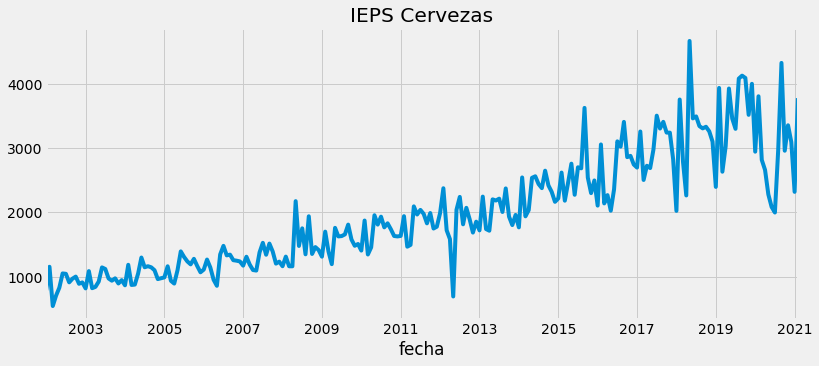

In [3]:
ieps_cervezasp=df['ieps_cervezas']
ieps_cervezas=ieps_cervezasp.dropna()
ieps_cervezas.plot(figsize=(12,5))
plt.title('IEPS Cervezas')
plt.show()

El histograma y la correspondiente función de densidad se ven como sigue:

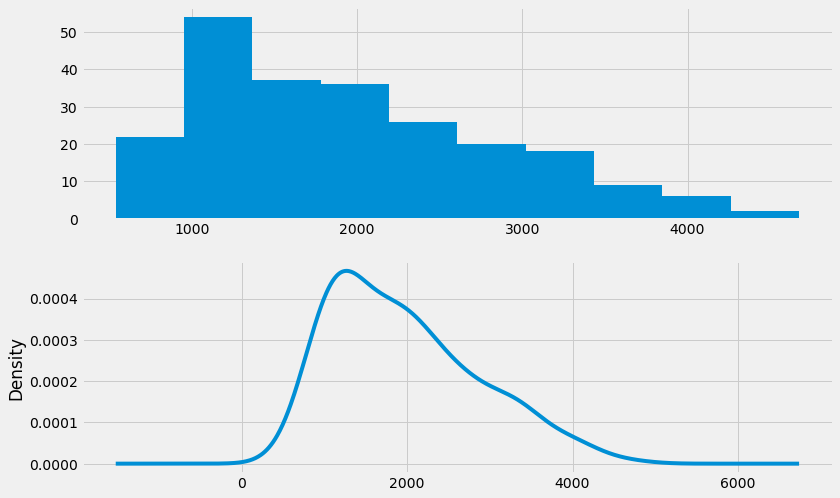

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_cervezas.hist(ax=ax1)
ieps_cervezas.plot(kind='kde',ax=ax2)
plt.show()

La descomposición de esta serie en sus componentes de tendencia, estacional y residuales, se ve como sigue:

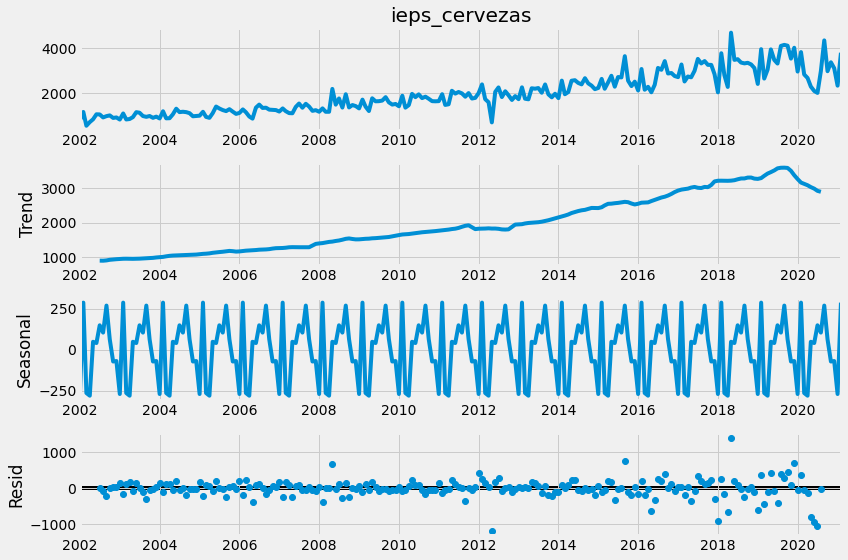

In [5]:
decomposition = seasonal_decompose(ieps_cervezas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

Los correlogramas, se ven como sigue:

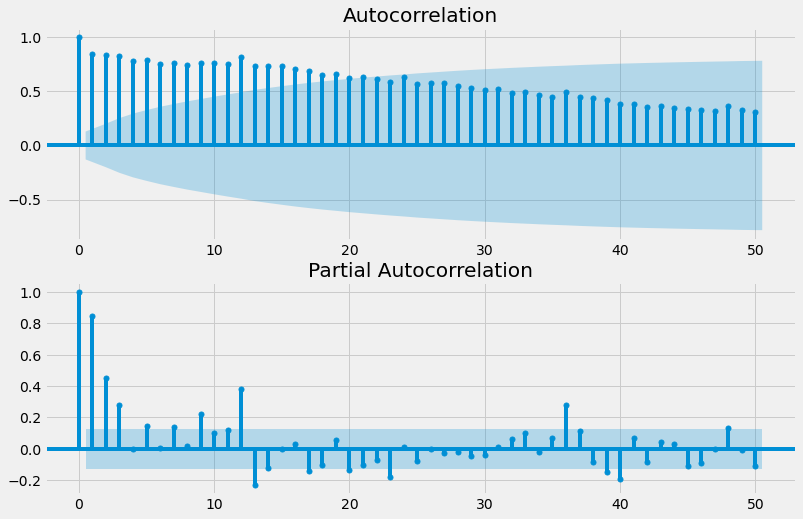

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=False, sharey=False)
ax1 = plot_acf(ieps_cervezas, lags=50, ax=ax1)
ax2 = plot_pacf(ieps_cervezas, lags=50, ax=ax2)
plt.show()

Aquí aplicó la prueba Dickey-Fuller que falla en rechazar que la serie tenga raíz unitaria. Con ello concluyó que la serie tiene raíz unitaria.

In [7]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_cervezas)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.716105
p-value                          0.842534
#Lags Used                      12.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


Generó la serie en primeras diferencias:

In [8]:
df_diff = ieps_cervezas.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-10-01   -1333.4
2020-11-01     971.5
2020-12-01    -745.4
2021-01-01     282.2
2021-02-01     597.8
Name: ieps_cervezas, dtype: float64

Y para la serie en primeras diferencias, rechazó la hipotesis de que la serie tiene raíz unitaria, en favor de la hipotesis que la serie es estacionaria. En otras palabras, puedo concluir que la serie en primeras diferencias sí es estacionaria.

In [9]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.498416e+00
p-value                        1.178360e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64


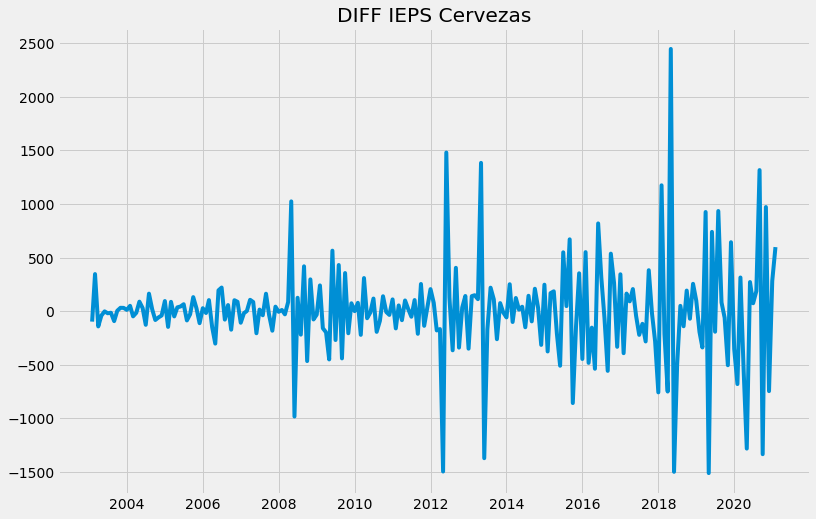

In [10]:
plt.plot(df_diff)
plt.title('DIFF IEPS Cervezas')
#plt.savefig('diffplot')
plt.show()

Aquí los correlogramas de la serie en primeras diferencias:

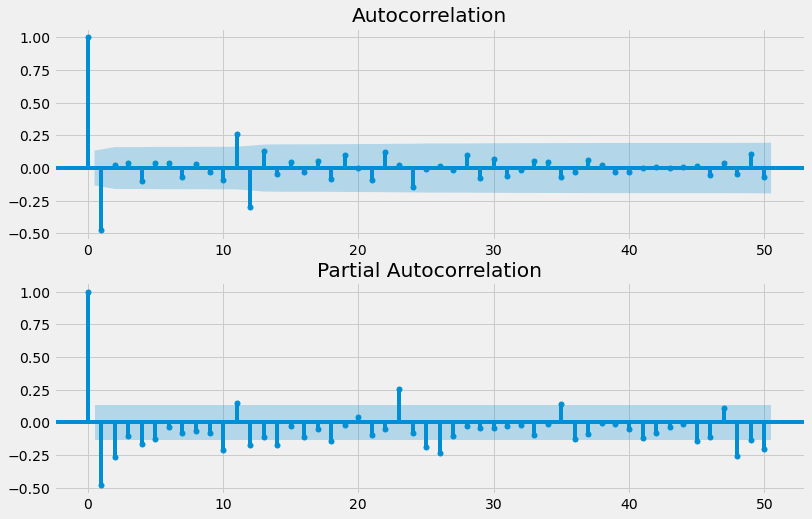

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

Y con este comando llegó a una nueva propuesta de modelo econométrico:

In [12]:
model = pm.auto_arima(ieps_cervezas, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3215.509, BIC=3229.028, Fit time=0.765 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3274.973, BIC=3281.732, Fit time=0.024 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3209.281, BIC=3222.801, Fit time=0.437 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3141.513, BIC=3155.032, Fit time=0.586 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3140.657, BIC=3157.557, Fit time=0.891 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3179.284, BIC=3192.804, Fit time=0.592 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3133.704, BIC=3153.983, Fit time=2.321 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3132.632, BIC=3156.291, Fit time=4.415 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3162.082, BIC=3182.361, Fit time=2.903 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3137.662, BIC=3164.701, Fit time=4.037 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3210.118, BIC=3227.018, Fit time=2.399 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3135.671, BIC=3155.951, Fit time=3.766 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3129.432, BIC=3156.471, Fit time=6.494 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3129.409, BIC=3153.069, Fit time=3.582 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=3174.904, BIC=3191.804, Fit time=1.014 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 1, 12); AIC=3128.580, BIC=3148.859, Fit time=4.524 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=3211.903, BIC=3228.802, Fit time=1.368 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3129.810, BIC=3153.469, Fit time=5.210 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=3132.568, BIC=3159.607, Fit time=4.221 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=3149.408, BIC=3166.307, Fit time=3.780 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3127.986, BIC=3151.645, Fit time=4.317 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 2, 12); AIC=3211.966, BIC=3232.245, Fit time=4.766 seconds
Fit ARIMA: order=(0, 1, 2) s

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  230
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1556.993
Date:                                 Thu, 18 Mar 2021   AIC                           3127.986
Time:                                         14:12:30   BIC                           3151.645
Sample:                                              0   HQIC                          3137.544
                                                 - 230                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3917      2.461     -0.159      0.874      -5.215       4.431
ma.L1         -0.7472      0.025    -30.127      0.000      -0.796      -0.699
ar.S.L12       0.3330      0.182      1.830      0.067      -0.024       0.690
ar.S.L24      -0.4459      0.081     -5.480      0.000      -0.605      -0.286
ma.S.L12      -0.9548      0.186     -5.126      0.000      -1.320      -0.590
ma.S.L24       0.3051      0.165      1.849      0.064      -0.018       0.629
sigma2      9.463e+04   4685.003     20.198      0.000    8.54e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               678.08
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               9.17   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Aplicó una técnica tradicional en los módelos de aprendizaje automático (*machine learning*) y divido la serie en una parte para entrenar el modelo y una parte para hacer las pruebas correspondientes.

<AxesSubplot:xlabel='fecha'>

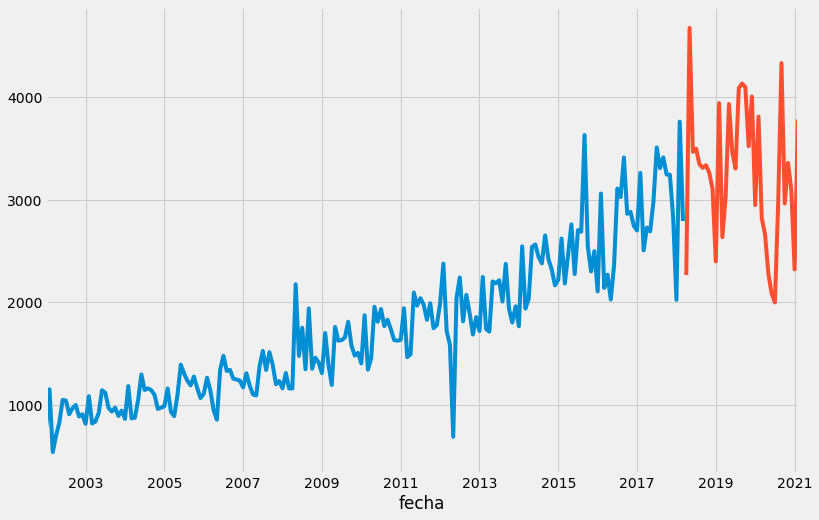

In [14]:
#divide into train and validation set
train = ieps_cervezas[:int(0.85*(len(ieps_cervezas)))]
test = ieps_cervezas[int(0.85*(len(ieps_cervezas))):]

#plotting the data
train.plot()
test.plot()

Entreno el modelo en la parte de prueba

In [15]:
model = SARIMAX(train,order=(0,1,1),seasonal_order=(2,1,2,12))
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           ieps_cervezas   No. Observations:                  195
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -1244.821
Date:                                 Thu, 18 Mar 2021   AIC                           2501.642
Time:                                         14:14:17   BIC                           2520.866
Sample:                                     01-01-2002   HQIC                          2509.435
                                          - 03-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9053      0.036    -25.347      0.000      -0.975      -0.835
ar.S.L12       0.8870      0.215      4.128      0.000       0.466       1.308
ar.S.L24      -0.2701      0.129     -2.101      0.036      -0.522      -0.018
ma.S.L12      -1.5564      0.232     -6.700      0.000      -2.012      -1.101
ma.S.L24       0.7171      0.199      3.605      0.000       0.327       1.107
sigma2      4.772e+04   2842.199     16.790      0.000    4.22e+04    5.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              2002.90
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):              10.62   Skew:                            -1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Y los resultados se ven bastante prometedores en esta parte de prueba:

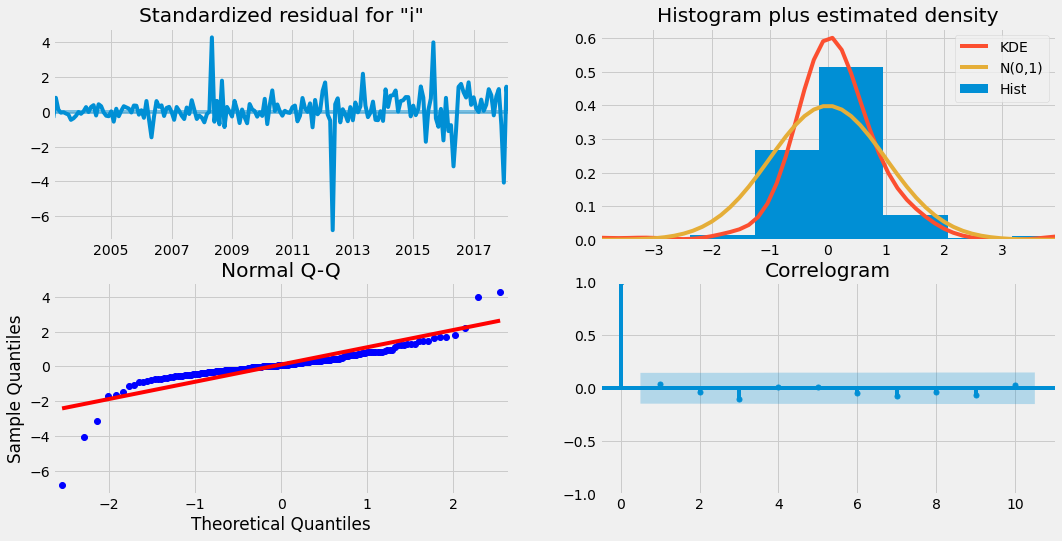

In [16]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics1')
plt.show()

Calculo los pronósticos para la parte de prueba

In [17]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index

Gráfico estos pronósticos:

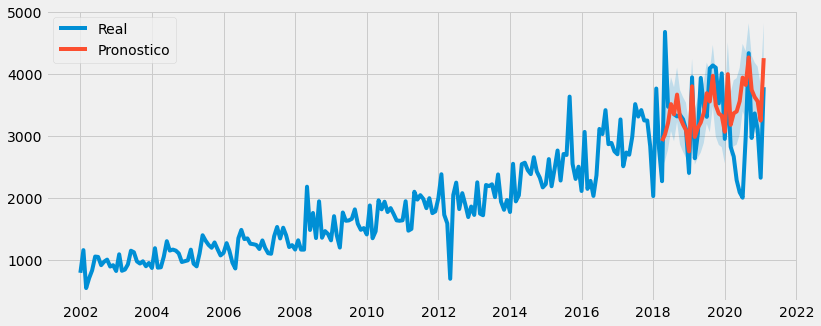

In [18]:
plt.figure(figsize=(12,5))
plt.plot(ieps_cervezas.index, ieps_cervezas, label='Real')
plt.plot(dates, mean, label='Pronostico')
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)
plt.legend()
plt.show()

In [19]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX Predictions')

In [20]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=2913.312962, expected=2265.1
predicted=3019.922039, expected=4674.6
predicted=3204.702779, expected=3467.0
predicted=3509.360047, expected=3497.7
predicted=3344.77736 , expected=3346.9
predicted=3663.009608, expected=3311.1
predicted=3297.408078, expected=3336.1
predicted=3180.203315, expected=3264.7
predicted=3088.974707, expected=3104.9
predicted=2745.518237, expected=2398.3
predicted=3797.205836, expected=3941.7
predicted=2979.054611, expected=2635.2
predicted=3126.873807, expected=3032.8
predicted=3213.559135, expected=3932.5
predicted=3372.664784, expected=3464.7
predicted=3685.90828 , expected=3304.0
predicted=3550.844252, expected=4087.5
predicted=3966.936722, expected=4133.5
predicted=3488.716756, expected=4097.5
predicted=3355.132479, expected=3522.4
predicted=3322.626845, expected=4005.9
predicted=3062.607976, expected=2947.7
predicted=3993.115302, expected=3811.7
predicted=3175.519973, expected=2819.5
predicted=3360.884282, expected=2662.8
predicted=3391.272495, ex

Aunque en esta parte solo gráfico la parte de prueba contra su pronóstico:

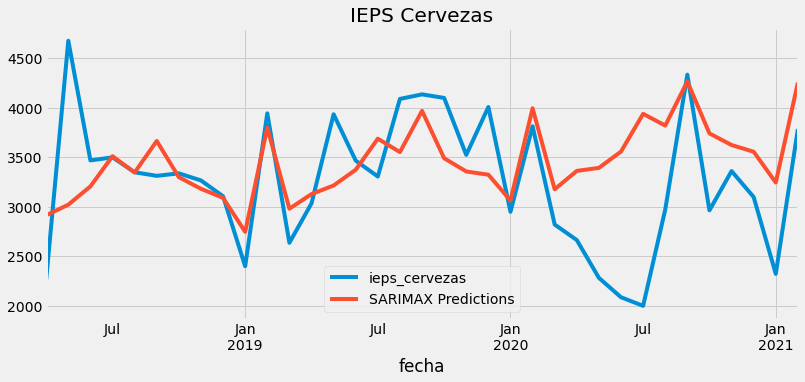

In [21]:
title = 'IEPS Cervezas'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

Calculo los estadísticos del modelo:

In [22]:
r2_score(test, predictions)

-0.03401392470860998

In [23]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 
evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0 -0.034014           486.540033       456241.172008   

   mean_absolute_percentage_error  
0                       17.205624

Y hago los pronósticos hacia adelante. Esta es la parte que más me interesa para cada serie.

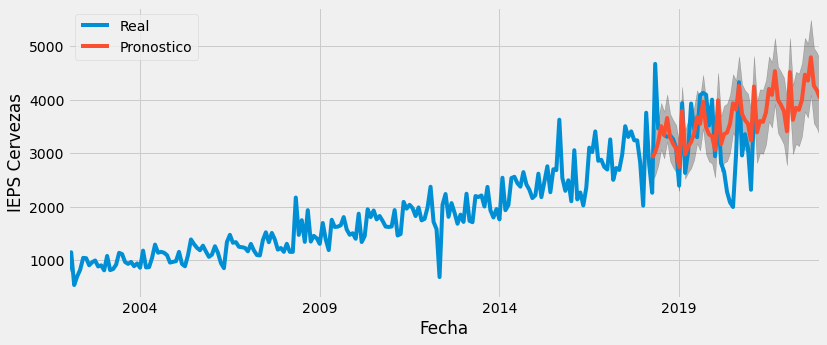

In [25]:
pred_f = results.get_forecast(steps=len(test)+22)
pred_ci = pred_f.conf_int()
ax = ieps_cervezas.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Cervezas')
plt.legend()
plt.show()

Y guardo los resultados en un csv para su posterior uso.

In [26]:
x=pred_f.predicted_mean
x.to_csv('arima_iepscervezas.csv')

### 3.2 IEPS Bebidas

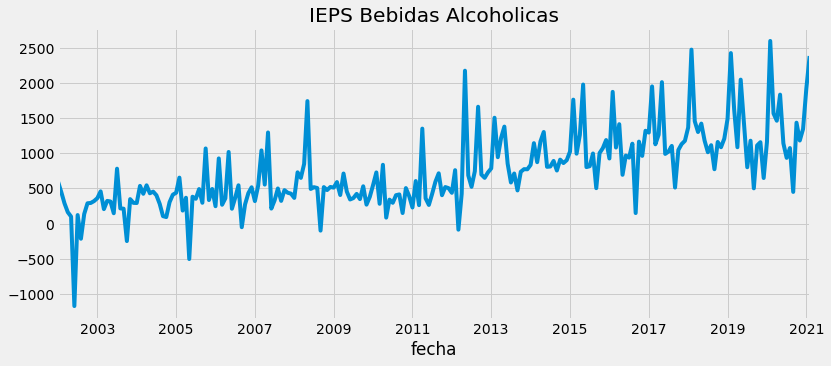

In [27]:
ieps_bebidasp=df['ieps_bebidas']
ieps_bebidas=ieps_bebidasp.dropna()
ieps_bebidas.plot(figsize=(12,5))
plt.title('IEPS Bebidas Alcoholicas')
plt.show()

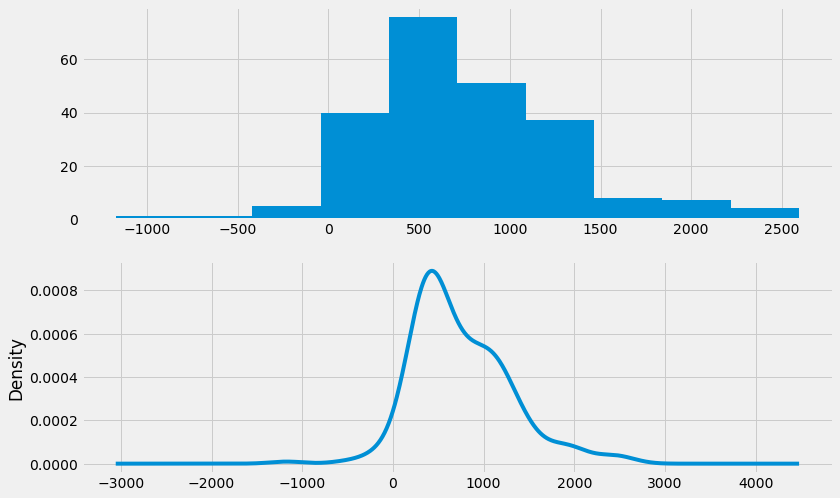

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_bebidas.hist(ax=ax1)
ieps_bebidas.plot(kind='kde',ax=ax2)
plt.show()

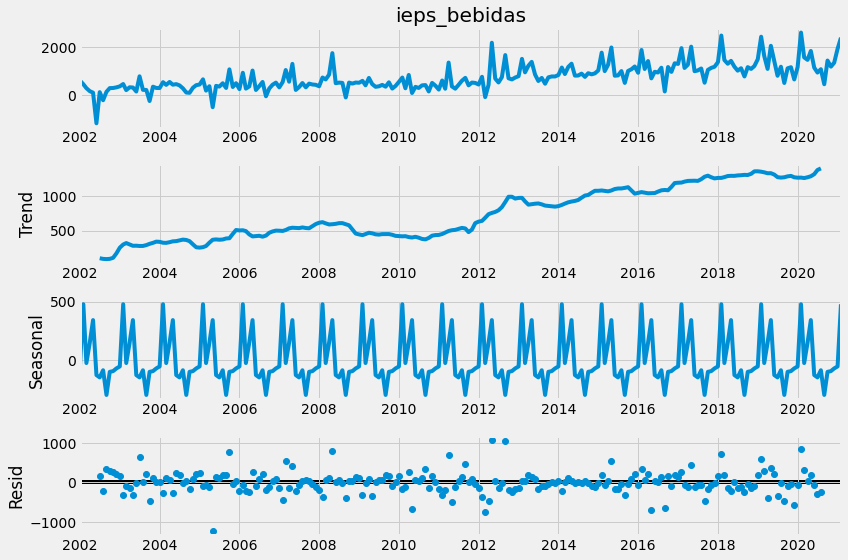

In [29]:
decomposition = seasonal_decompose(ieps_bebidas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

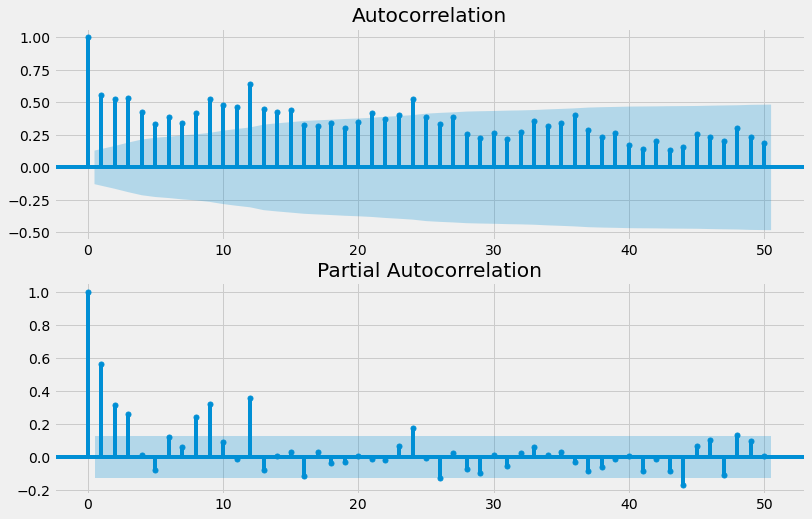

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=False, sharey=False)
ax1 = plot_acf(ieps_bebidas, lags=50, ax=ax1)
ax2 = plot_pacf(ieps_bebidas, lags=50, ax=ax2)
plt.show()

In [31]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_bebidas)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.728073
p-value                          0.839343
#Lags Used                      11.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


In [32]:
df_diff = ieps_bebidas.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-10-01    374.5
2020-11-01   -299.5
2020-12-01    672.8
2021-01-01     64.7
2021-02-01   -975.6
Name: ieps_bebidas, dtype: float64

In [33]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.055025e+00
p-value                        1.251126e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.040000e+02
Critical Value (1%)           -3.462818e+00
Critical Value (5%)           -2.875815e+00
Critical Value (10%)          -2.574379e+00
dtype: float64


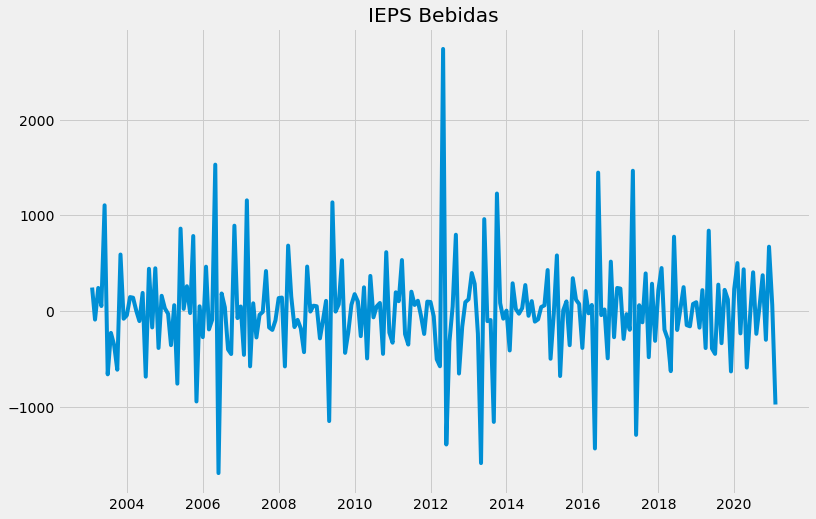

In [34]:
plt.plot(df_diff)
plt.title('IEPS Bebidas')
#plt.savefig('diffplot')
plt.show()

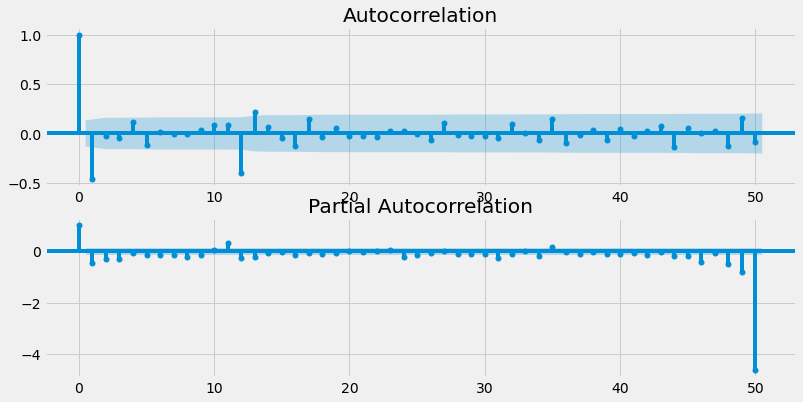

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [41]:
model = pm.auto_arima(ieps_bebidas, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=3260.639, BIC=3274.159, Fit time=1.068 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3331.089, BIC=3337.849, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3229.225, BIC=3242.745, Fit time=0.448 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3142.472, BIC=3155.992, Fit time=0.771 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3145.709, BIC=3162.608, Fit time=0.973 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3206.336, BIC=3216.475, Fit time=0.244 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3143.741, BIC=3160.641, Fit time=2.442 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3141.720, BIC=3161.999, Fit time=4.269 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3143.043, BIC=3166.702, Fit time=5.539 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=3262.668, BIC=3279.568, Fit time=6.342 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3143.098, BIC=3166.758, Fit time=9.673 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=3145.743, BIC=3172.782, Fit time=7.159 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=3147.645, BIC=3171.304, Fit time=6.668 seconds
Total fit time: 45.629 seconds


In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  230
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -1564.860
Date:                                 Thu, 18 Mar 2021   AIC                           3141.720
Time:                                         14:27:13   BIC                           3161.999
Sample:                                              0   HQIC                          3149.912
                                                 - 230                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0311      1.296      0.024      0.981      -2.509       2.571
ma.L1         -0.9296      0.032    -29.057      0.000      -0.992      -0.867
ar.S.L12      -0.8894      0.137     -6.506      0.000      -1.157      -0.621
ma.S.L12       0.2723      6.731      0.040      0.968     -12.921      13.466
ma.S.L24      -0.7265      4.866     -0.149      0.881     -10.263       8.810
sigma2      9.968e+04   6.58e+05      0.151      0.880   -1.19e+06    1.39e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               245.46
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.03
Prob(H) (two-sided):                  0.10   Kurtosis:                         7.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='fecha'>

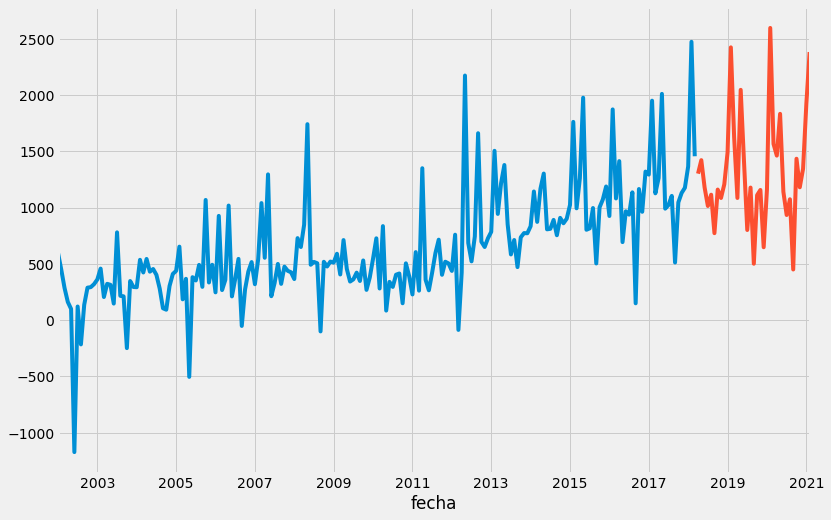

In [43]:
#divide into train and validation set
train = ieps_bebidas[:int(0.85*(len(ieps_bebidas)))]
test = ieps_bebidas[int(0.85*(len(ieps_bebidas))):]

#plotting the data
train.plot()
test.plot()

In [46]:
model = SARIMAX(train,order=(0,1,1),seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       ieps_bebidas   No. Observations:                  195
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1319.602
Date:                            Thu, 18 Mar 2021   AIC                           2647.205
Time:                                    14:28:06   BIC                           2660.021
Sample:                                01-01-2002   HQIC                          2652.400
                                     - 03-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9235      0.038    -24.093      0.000      -0.999      -0.848
ar.S.L12       0.1512      0.074      2.053      0.040       0.007       0.296
ma.S.L12      -0.8714      0.076    -11.464      0.000      -1.020      -0.722
sigma2      1.082e+05   7499.310     14.426      0.000    9.35e+04    1.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):               167.34
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

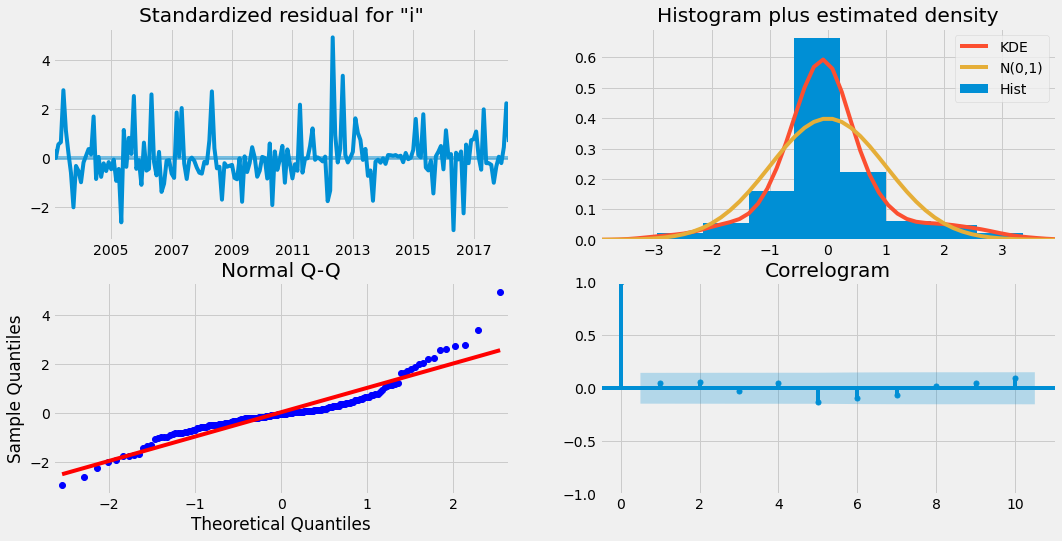

In [47]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

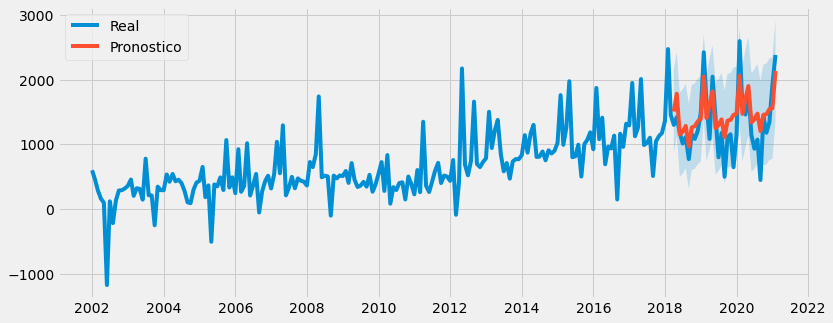

In [49]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
plt.figure(figsize=(12,5))
# Plot past CO2 levels
plt.plot(ieps_bebidas.index, ieps_bebidas, label='Real')
# Plot the prediction means as line
plt.plot(dates, mean, label='Pronostico')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)
# Plot legend and show figure
plt.legend()
#plt.savefig('predtest')
plt.show()

In [50]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX Predictions')

In [51]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=1507.524569, expected=1300.6
predicted=1781.669016, expected=1420.4
predicted=1151.168913, expected=1178.3
predicted=1197.453198, expected=1013.3
predicted=1284.671642, expected=1113.5
predicted=967.3181938, expected=772.1
predicted=1260.476543, expected=1159.4
predicted=1280.927489, expected=1084.6
predicted=1353.818086, expected=1205.8
predicted=1395.101265, expected=1489.0
predicted=2046.836701, expected=2422.3
predicted=1404.224941, expected=1624.9
predicted=1618.395472, expected=1084.7
predicted=1821.077656, expected=2044.9
predicted=1249.346299, expected=1412.0
predicted=1297.760031, expected=800.2
predicted=1385.918661, expected=1177.0
predicted=1110.029402, expected=500.6
predicted=1366.83463 , expected=1109.6
predicted=1377.707636, expected=1155.8
predicted=1454.603429, expected=647.2
predicted=1473.37141 , expected=1159.6
predicted=2056.410054, expected=2594.7
predicted=1470.32762 , expected=1564.6
predicted=1708.953026, expected=1461.0
predicted=1900.830608, expect

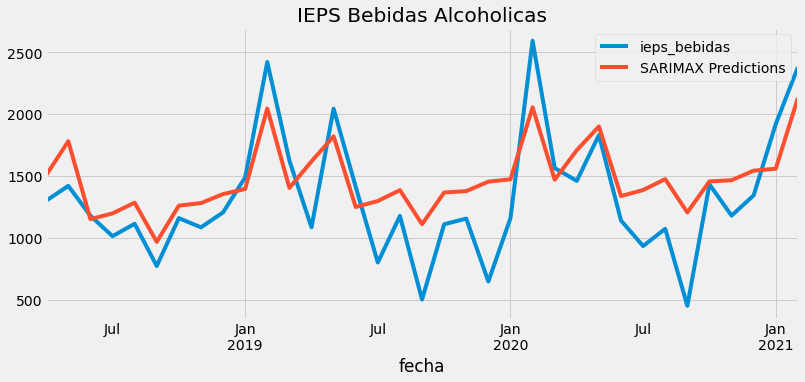

In [52]:
title = 'IEPS Bebidas Alcoholicas'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [53]:
r2_score(test, predictions)

0.5177215462024666

In [54]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.517722           285.629299       116920.249806   

   mean_absolute_percentage_error  
0                       29.532353

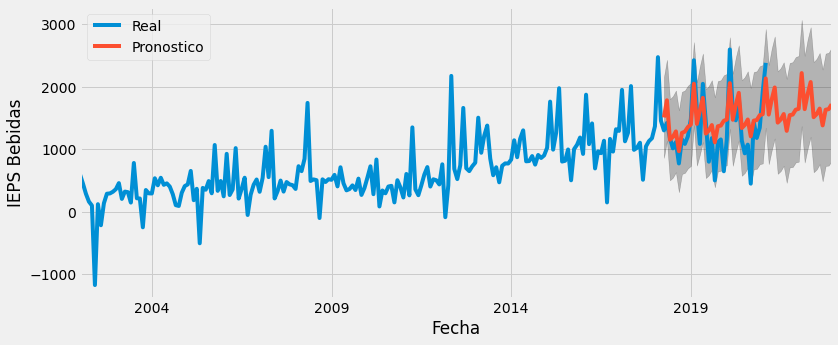

In [56]:
pred_f = results.get_forecast(steps=len(test)+22)
pred_ci = pred_f.conf_int()
ax = ieps_bebidas.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Bebidas')
plt.legend()
plt.show()

In [57]:
x=pred_f.predicted_mean
x.to_csv('arima_iepsbebidas.csv')

### 3.3 IEPS Tabacos

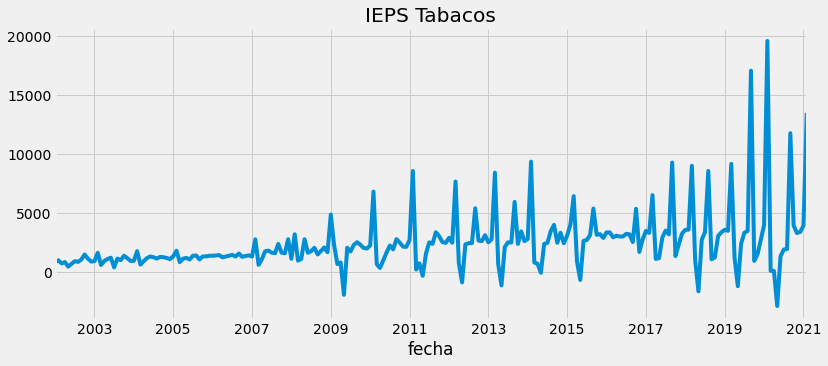

In [58]:
ieps_tabacosp=df['ieps_tabacos']
ieps_tabacos=ieps_tabacosp.dropna()
ieps_tabacos.plot(figsize=(12,5))
plt.title('IEPS Tabacos')
plt.show()

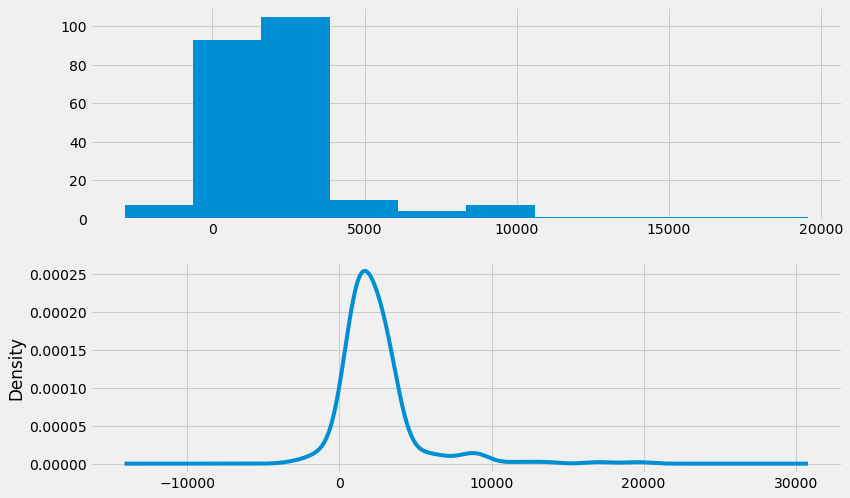

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_tabacos.hist(ax=ax1)
ieps_tabacos.plot(kind='kde',ax=ax2)
plt.show()

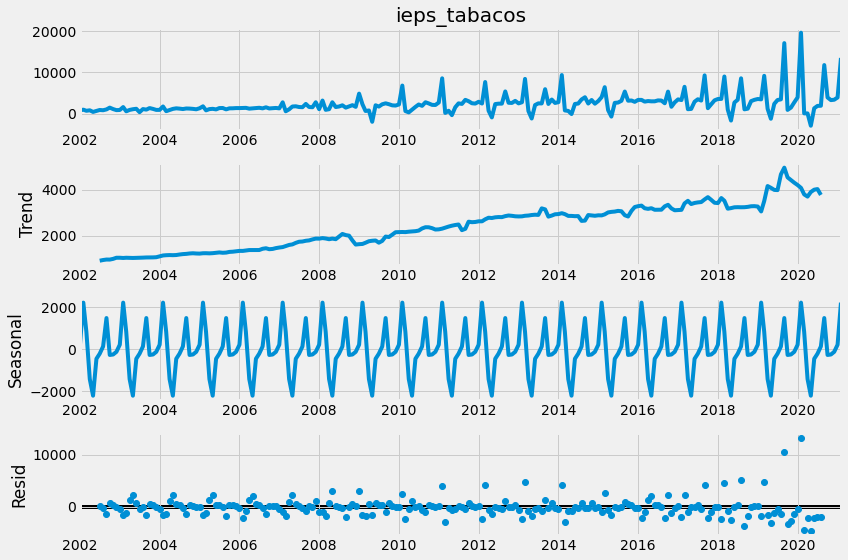

In [60]:
decomposition = seasonal_decompose(ieps_tabacos, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

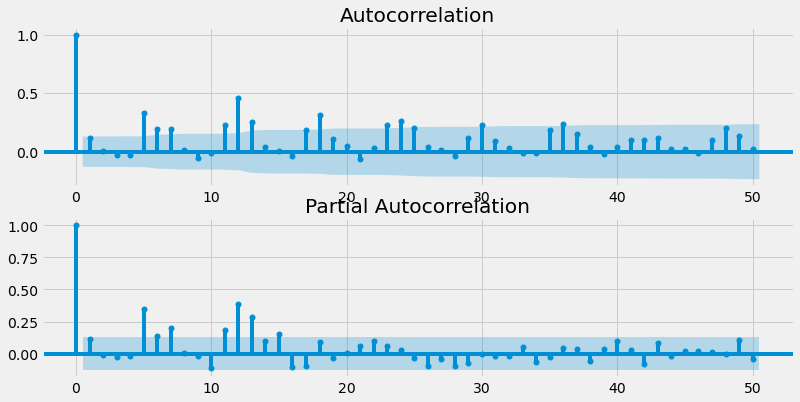

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ieps_tabacos, lags=50, ax=ax1)
ax2 = plot_pacf(ieps_tabacos, lags=50, ax=ax2)
plt.show()

In [62]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_tabacos)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.577449
p-value                          0.875997
#Lags Used                      15.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [63]:
df_diff = ieps_tabacos.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-10-01    8296.4
2020-11-01   -1199.8
2020-12-01   -1150.8
2021-01-01    -683.2
2021-02-01   -6065.1
Name: ieps_tabacos, dtype: float64

In [64]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.719402e+00
p-value                        3.514241e-09
#Lags Used                     1.500000e+01
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


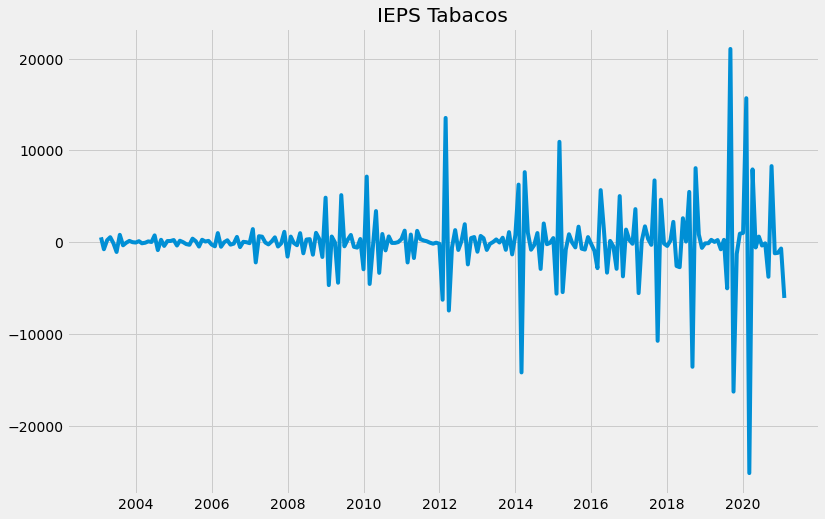

In [65]:
plt.plot(df_diff)
plt.title('IEPS Tabacos')
#plt.savefig('diffplot')
plt.show()

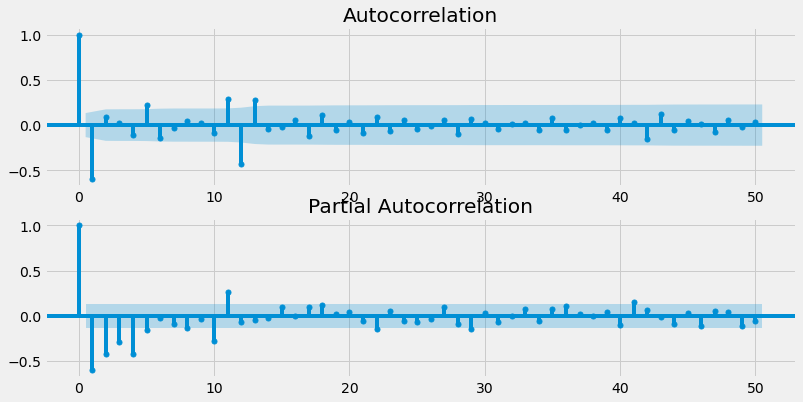

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [67]:
model = pm.auto_arima(ieps_tabacos, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=4130.659, BIC=4144.179, Fit time=0.927 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4219.963, BIC=4226.723, Fit time=0.185 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4081.217, BIC=4094.736, Fit time=0.225 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3943.968, BIC=3957.487, Fit time=0.782 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3945.941, BIC=3962.841, Fit time=1.162 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4015.034, BIC=4025.174, Fit time=0.272 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3945.940, BIC=3962.840, Fit time=2.943 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3953.413, BIC=3973.693, Fit time=4.301 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3930.195, BIC=3947.095, Fit time=1.207 seconds
Fit ARIMA: order=(1, 1, 0) s

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3941.163, BIC=3961.442, Fit time=2.087 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4129.547, BIC=4139.687, Fit time=0.985 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3947.087, BIC=3970.746, Fit time=2.306 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3938.285, BIC=3958.564, Fit time=1.860 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3990.235, BIC=4003.755, Fit time=0.417 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3949.664, BIC=3969.944, Fit time=6.075 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3934.203, BIC=3957.863, Fit time=7.633 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3925.294, BIC=3945.574, Fit time=1.573 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4029.300, BIC=4046.199, Fit time=0.290 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=3947.413, BIC=3974.453, Fit time=2.006 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3928.580, BIC=3952.239, Fit time=1.812 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3983.495, BIC=4000.394, Fit time=0.732 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3927.186, BIC=3950.846, Fit time=6.756 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3929.498, BIC=3956.538, Fit time=7.147 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3922.280, BIC=3945.939, Fit time=2.005 seconds
Fit ARIMA: order=(3, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4005.138, BIC=4025.418, Fit time=0.990 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3955.134, BIC=3982.173, Fit time=2.176 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3981.018, BIC=4001.297, Fit time=0.969 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(3, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3942.679, BIC=3969.718, Fit time=6.704 seconds
Fit ARIMA: order=(4, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3937.797, BIC=3964.836, Fit time=4.026 seconds
Total fit time: 71.584 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  230
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1954.140
Date:                            Thu, 18 Mar 2021   AIC                           3922.280
Time:                                    14:33:39   BIC                           3945.939
Sample:                                         0   HQIC                          3931.837
                                            - 230                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4567      1.162      0.393      0.694      -1.821       2.734
ar.L1         -0.3529      0.056     -6.286      0.000      -0.463      -0.243
ar.L2         -0.2322      0.100     -2.314      0.021      -0.429      -0.036
ar.L3         -0.1546      0.062     -2.501      0.012      -0.276      -0.033
ma.L1         -1.0000      0.050    -20.072      0.000      -1.098      -0.902
ma.S.L12      -0.6404      0.053    -11.996      0.000      -0.745      -0.536
sigma2      3.754e+06   1.41e-08   2.66e+14      0.000    3.75e+06    3.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):              4328.26
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              31.82   Skew:                             3.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.06e+31. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='fecha'>

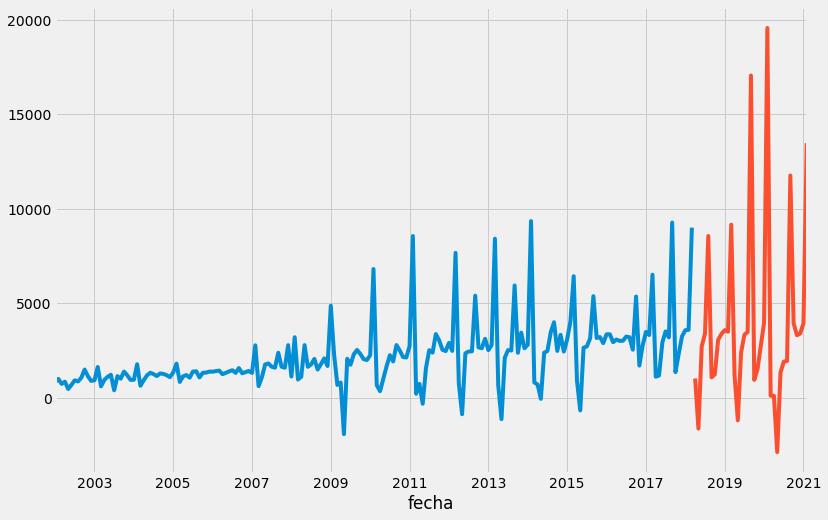

In [69]:
#divide into train and validation set
train = ieps_tabacos[:int(0.85*(len(ieps_tabacos)))]
test = ieps_tabacos[int(0.85*(len(ieps_tabacos))):]

#plotting the data
train.plot()
test.plot()

In [70]:
model = SARIMAX(train,order=(3,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       ieps_tabacos   No. Observations:                  195
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1562.382
Date:                            Thu, 18 Mar 2021   AIC                           3136.763
Time:                                    14:34:08   BIC                           3155.987
Sample:                                01-01-2002   HQIC                          3144.556
                                     - 03-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3962      0.054     -7.293      0.000      -0.503      -0.290
ar.L2         -0.2326      0.096     -2.411      0.016      -0.422      -0.044
ar.L3         -0.0620      0.105     -0.592      0.554      -0.267       0.143
ma.L1         -1.0000      0.060    -16.800      0.000      -1.117      -0.883
ma.S.L12      -0.6324      0.033    -19.332      0.000      -0.697      -0.568
sigma2      1.587e+06   3.75e-08   4.23e+13      0.000    1.59e+06    1.59e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               245.79
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              21.26   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.62e+28. Standard errors may be unstable.
"""

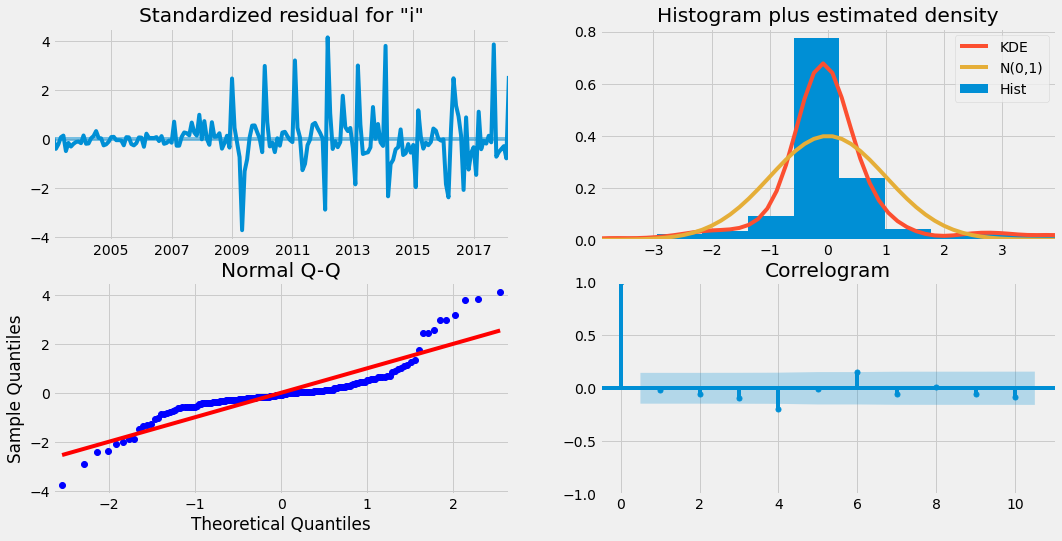

In [73]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

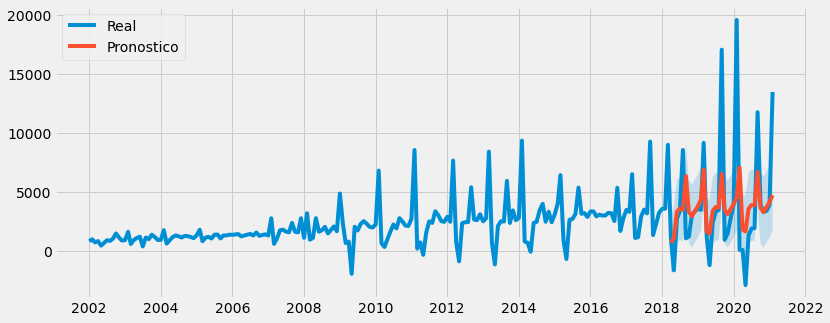

In [74]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
plt.figure(figsize=(12,5))
# Plot past CO2 levels
plt.plot(ieps_tabacos.index, ieps_tabacos, label='Real')
# Plot the prediction means as line
plt.plot(dates, mean, label='Pronostico')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)
# Plot legend and show figure
plt.legend()
#plt.savefig('predtest')
plt.show()

In [75]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX Predictions')

In [76]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=704.485731 , expected=1012.0
predicted=1112.707903, expected=-1640.7
predicted=3346.118944, expected=2717.9
predicted=3589.471922, expected=3385.9
predicted=3489.804471, expected=8556.1
predicted=6344.329035, expected=1073.4
predicted=3312.855095, expected=1227.5
predicted=2941.160052, expected=3056.3
predicted=3361.013023, expected=3365.8
predicted=3801.35432 , expected=3568.5
predicted=4371.883828, expected=3483.9
predicted=6886.330819, expected=9157.3
predicted=1638.743355, expected=1209.5
predicted=1480.378676, expected=-1202.7
predicted=3409.759858, expected=2391.4
predicted=3716.711843, expected=3325.3
predicted=3697.67069 , expected=3477.4
predicted=6524.295188, expected=17051.8
predicted=3481.182099, expected=936.9
predicted=3115.592036, expected=1499.2
predicted=3537.462097, expected=2741.8
predicted=3976.305419, expected=3961.2
predicted=4546.581005, expected=19570.0
predicted=7061.352035, expected=100.8
predicted=1813.788061, expected=91.2
predicted=1655.354441, ex

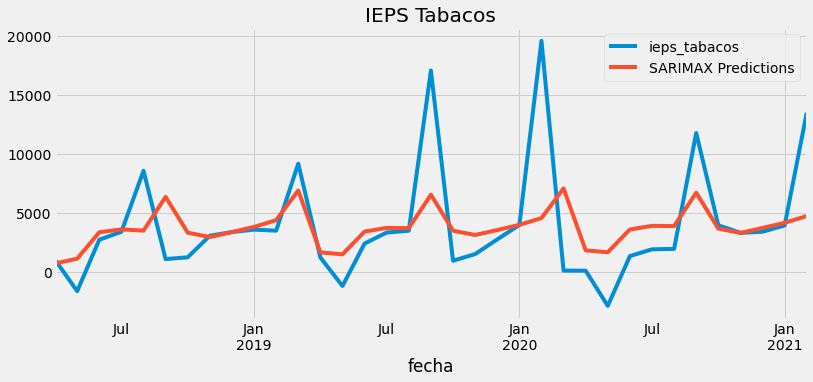

In [77]:
title = 'IEPS Tabacos'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [78]:
r2_score(test, predictions)

0.251494781853584

In [79]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  0.251495          2546.819849        1.754310e+07   

   mean_absolute_percentage_error  
0                      323.748021

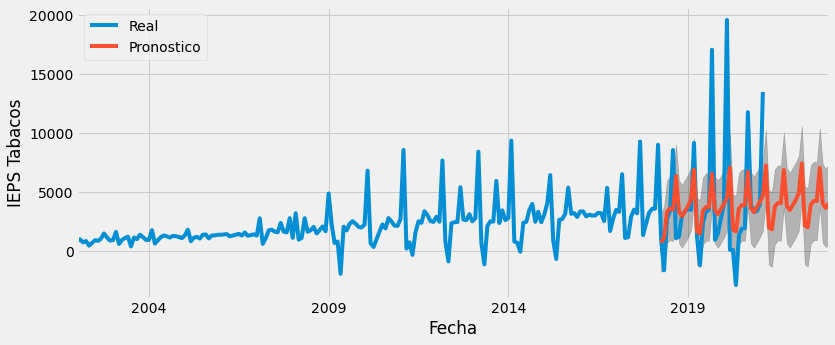

In [80]:
pred_f = results.get_forecast(steps=len(test)+22)
pred_ci = pred_f.conf_int()
ax = ieps_tabacos.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Tabacos')
plt.legend()
plt.show()

In [81]:
x=pred_f.predicted_mean
x.to_csv('arima_iepstabacos.csv')

### 3.4 IEPS Gasolinas

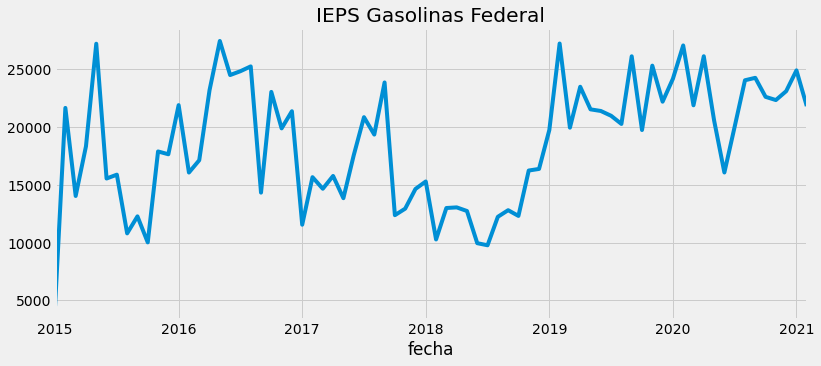

In [82]:
ieps_gasp=df['ieps_gasolinas']
ieps_gas=ieps_gasp.dropna()
ieps_gas.plot(figsize=(12,5))
plt.title('IEPS Gasolinas Federal')
plt.show()

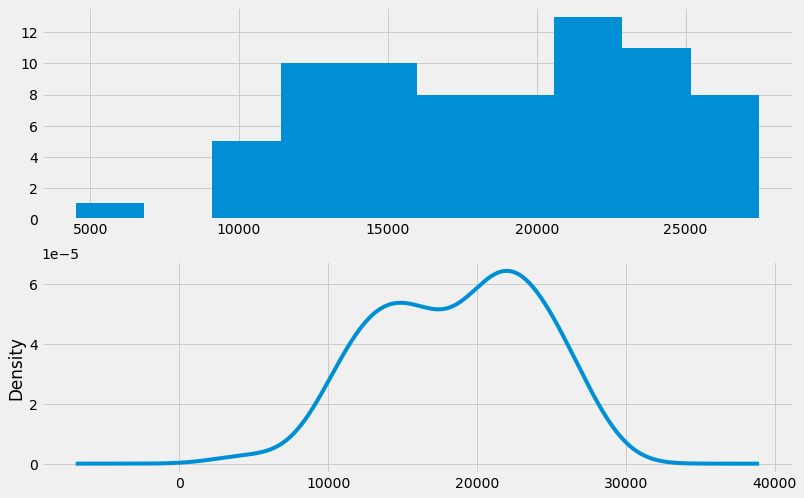

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,8))
ieps_gas.hist(ax=ax1)
ieps_gas.plot(kind='kde',ax=ax2)
plt.show()

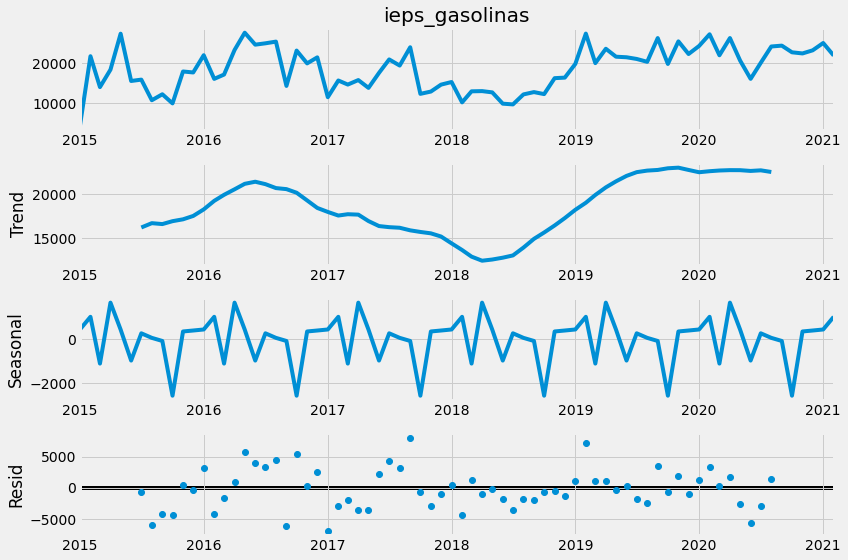

In [84]:
decomposition = seasonal_decompose(ieps_gas, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

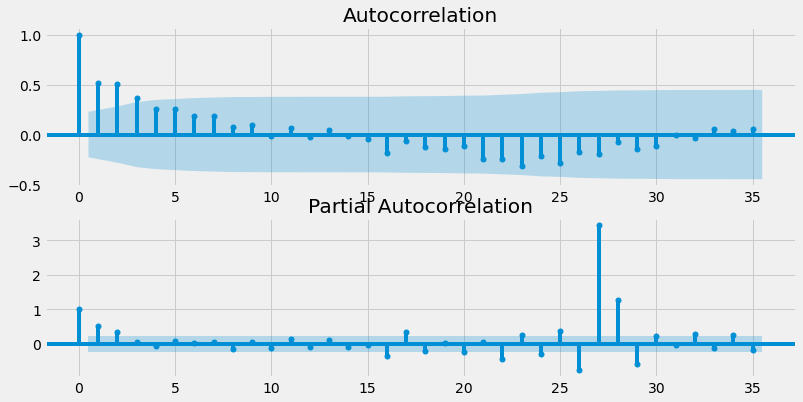

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ieps_gas, lags=35, ax=ax1)
ax2 = plot_pacf(ieps_gas, lags=35, ax=ax2)
plt.show()

In [88]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ieps_gas)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.678816
p-value                         0.077776
#Lags Used                      1.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [89]:
df_diff = ieps_gas.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-10-01    4737.9
2020-11-01   -5856.0
2020-12-01    3891.6
2021-01-01    -179.3
2021-02-01   -5981.4
Name: ieps_gasolinas, dtype: float64

In [90]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.810802
p-value                         0.056747
#Lags Used                     11.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


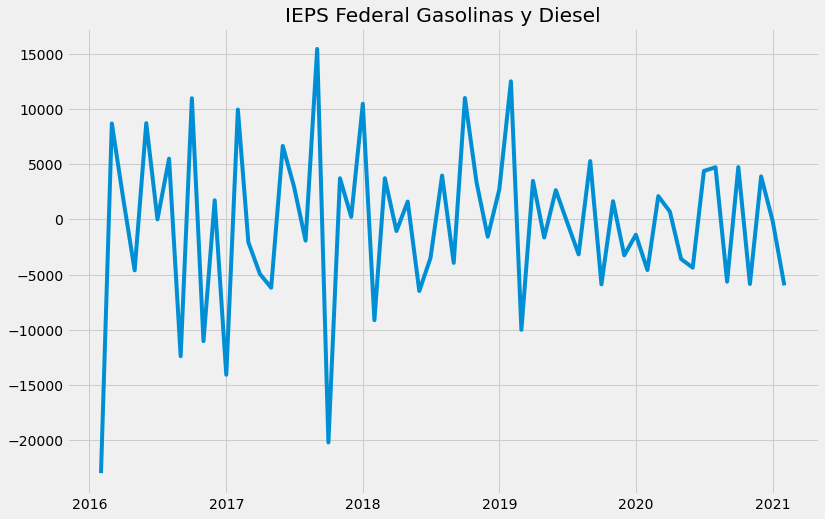

In [91]:
plt.plot(df_diff)
plt.title('IEPS Federal Gasolinas y Diesel')
#plt.savefig('diffplot')
plt.show()

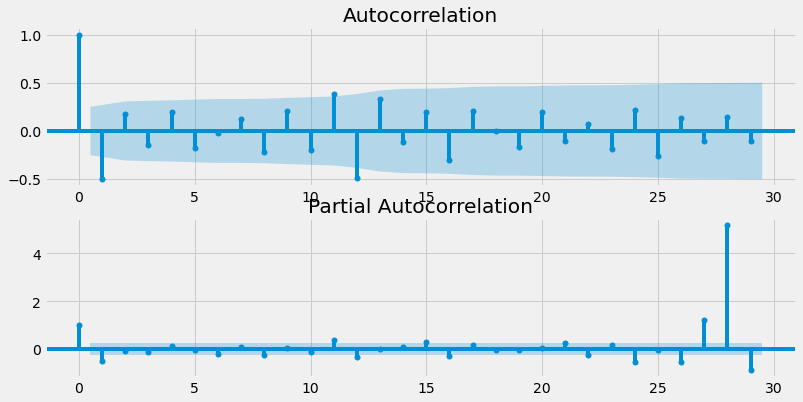

In [94]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=29, ax=ax1)
ax2 = plot_pacf(df_diff, lags=29, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [95]:
model = pm.auto_arima(ieps_gas, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=1234.808, BIC=1243.252, Fit time=0.114 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1262.407, BIC=1266.629, Fit time=0.166 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1225.768, BIC=1234.212, Fit time=0.147 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1211.127, BIC=1219.571, Fit time=0.596 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1220.832, BIC=1231.387, Fit time=0.177 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1246.584, BIC=1252.917, Fit time=0.035 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1220.801, BIC=1231.356, Fit time=0.281 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1214.546, BIC=1227.212, Fit time=1.464 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1212.990, BIC=1223.545, Fit time=0.505 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1218.304, BIC=1224.636, Fit time=0.242 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=1215.407, BIC=1225.961, Fit time=0.623 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=1214.807, BIC=1227.473, Fit time=0.684 seconds
Total fit time: 5.039 seconds


C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [96]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   74
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -601.564
Date:                            Thu, 18 Mar 2021   AIC                           1211.127
Time:                                    14:38:12   BIC                           1219.571
Sample:                                         0   HQIC                          1214.436
                                             - 74                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -122.2622    173.758     -0.704      0.482    -462.822     218.298
ma.L1         -0.3791      0.125     -3.023      0.003      -0.625      -0.133
ma.S.L12      -0.9931      0.177     -5.616      0.000      -1.340      -0.647
sigma2      1.708e+07   3.63e-05    4.7e+11      0.000    1.71e+07    1.71e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.13
Prob(Q):                              0.97   Prob(JB):                         0.13
Heteroskedasticity (H):               0.34   Skew:                            -0.62
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.99e+31. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='fecha'>

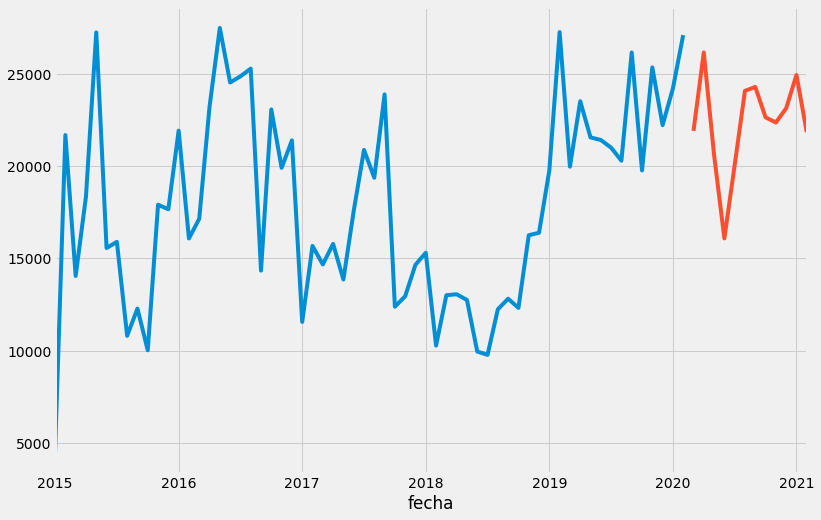

In [97]:
#divide into train and validation set
train = ieps_gas[:int(0.85*(len(ieps_gas)))]
test = ieps_gas[int(0.85*(len(ieps_gas))):]

#plotting the data
train.plot()
test.plot()

In [98]:
model = SARIMAX(train,order=(0,1,1),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     ieps_gasolinas   No. Observations:                   62
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -486.070
Date:                            Thu, 18 Mar 2021   AIC                            978.141
Time:                                    14:38:36   BIC                            983.816
Sample:                                01-01-2015   HQIC                           980.294
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3836      0.139     -2.753      0.006      -0.657      -0.111
ma.S.L12      -0.9827      0.187     -5.258      0.000      -1.349      -0.616
sigma2      1.892e+07   9.92e-09   1.91e+15      0.000    1.89e+07    1.89e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 3.42
Prob(Q):                              0.81   Prob(JB):                         0.18
Heteroskedasticity (H):               0.32   Skew:                            -0.64
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.99e+30. Standard errors may be unstable.
"""

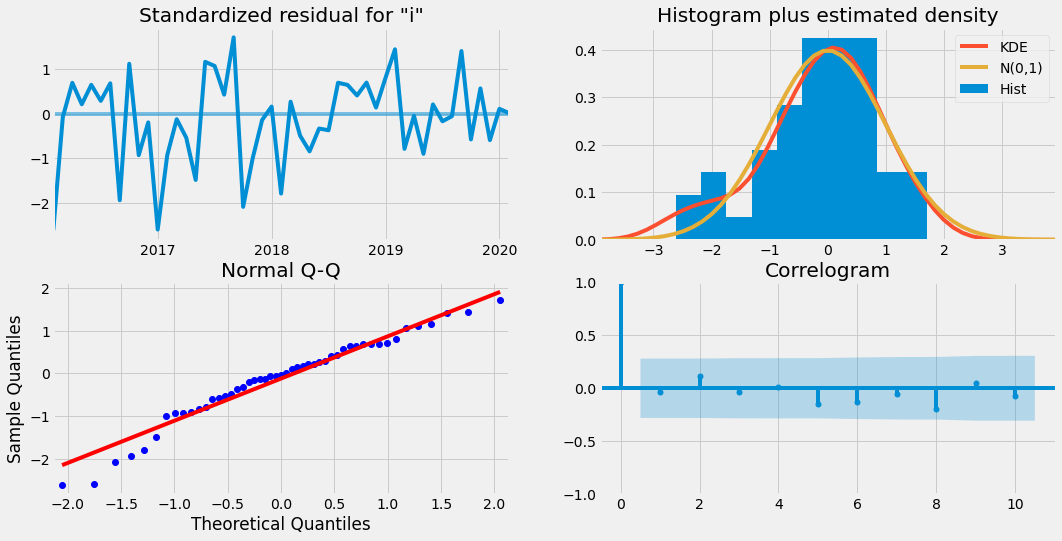

In [99]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

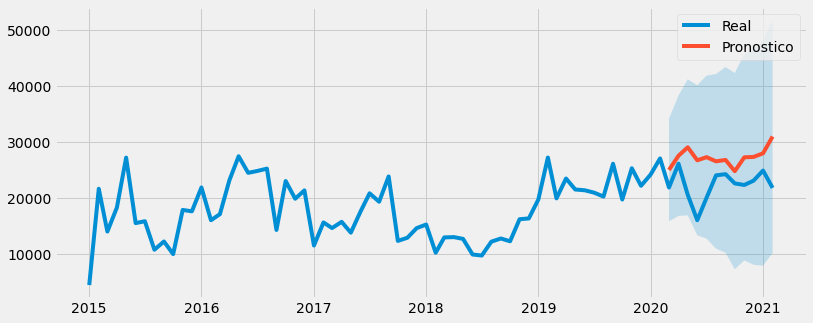

In [100]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
plt.figure(figsize=(12,5))
# Plot past CO2 levels
plt.plot(ieps_gas.index, ieps_gas, label='Real')
# Plot the prediction means as line
plt.plot(dates, mean, label='Pronostico')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)
# Plot legend and show figure
plt.legend()
#plt.savefig('predtest')
plt.show()

In [101]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX Predictions')

In [102]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=25030.62746, expected=21898.6
predicted=27566.27752, expected=26143.5
predicted=29068.24698, expected=20594.5
predicted=26749.36184, expected=16076.7
predicted=27310.07618, expected=20048.2
predicted=26567.41723, expected=24064.3
predicted=26813.36829, expected=24275.4
predicted=24810.04574, expected=22629.9
predicted=27283.4664 , expected=22350.0
predicted=27347.86787, expected=23118.7
predicted=27996.16644, expected=24921.5
predicted=30988.3307 , expected=21829.5


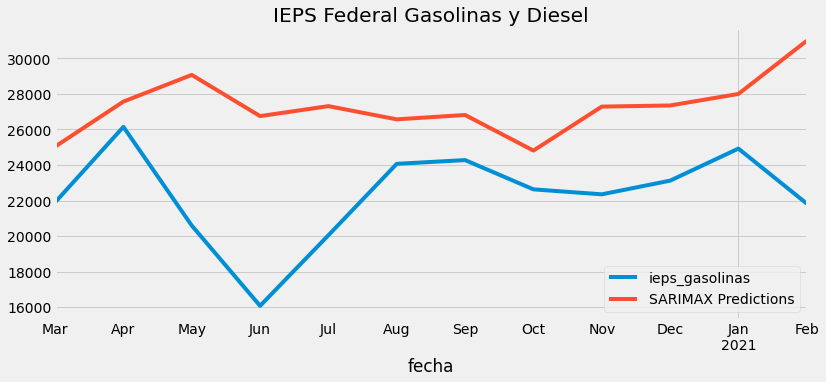

In [103]:
title = 'IEPS Federal Gasolinas y Diesel'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [104]:
r2_score(test, predictions)

-4.27037457989962

In [105]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0 -4.270375          4965.037721        3.360845e+07   

   mean_absolute_percentage_error  
0                       24.054119

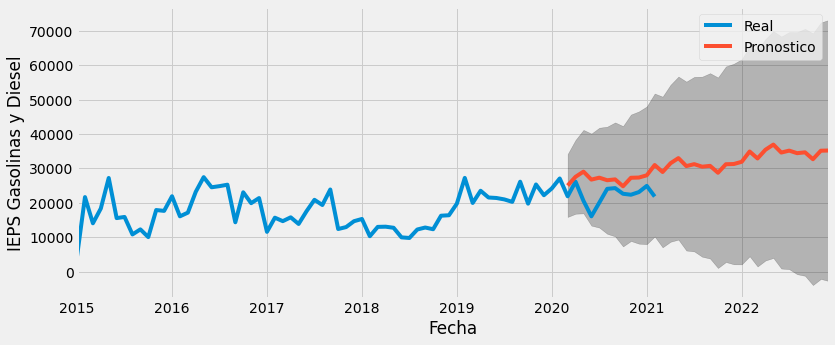

In [106]:
pred_f = results.get_forecast(steps=len(test)+22)
pred_ci = pred_f.conf_int()
ax = ieps_gas.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IEPS Gasolinas y Diesel')
plt.legend()
plt.show()

In [107]:
x=pred_f.predicted_mean
x.to_csv('arima_iepsgas.csv')

### 3.5 Ingresos Petroleros / RFP Petroleros

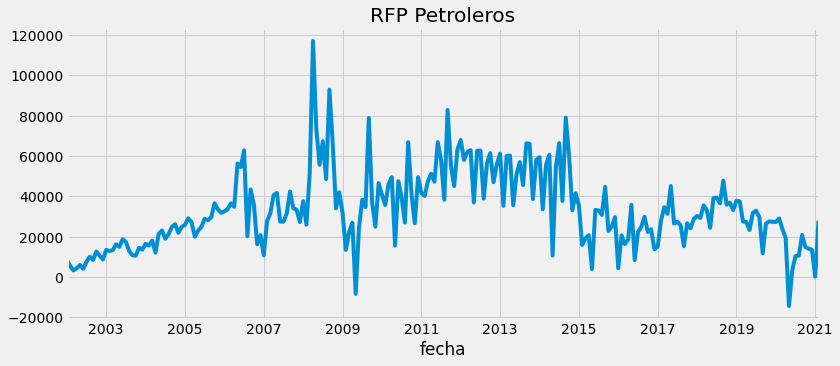

In [108]:
fmpedp=df['rfp_petroleros']
fmped=fmpedp.dropna()
fmped.plot(figsize=(12,5))
plt.title('RFP Petroleros')
plt.show()

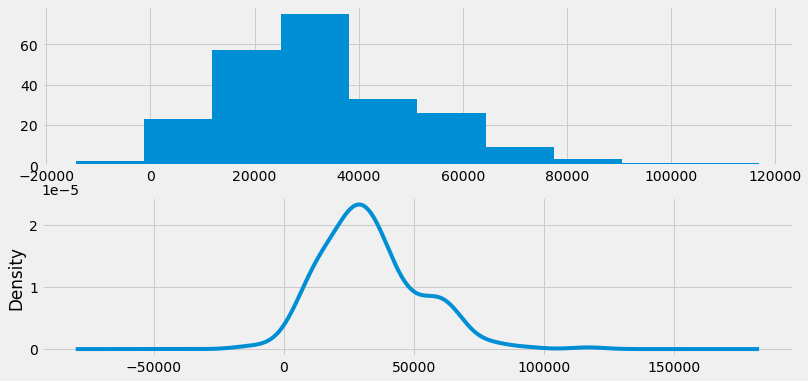

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))
fmped.hist(ax=ax1)
fmped.plot(kind='kde',ax=ax2)
plt.show()

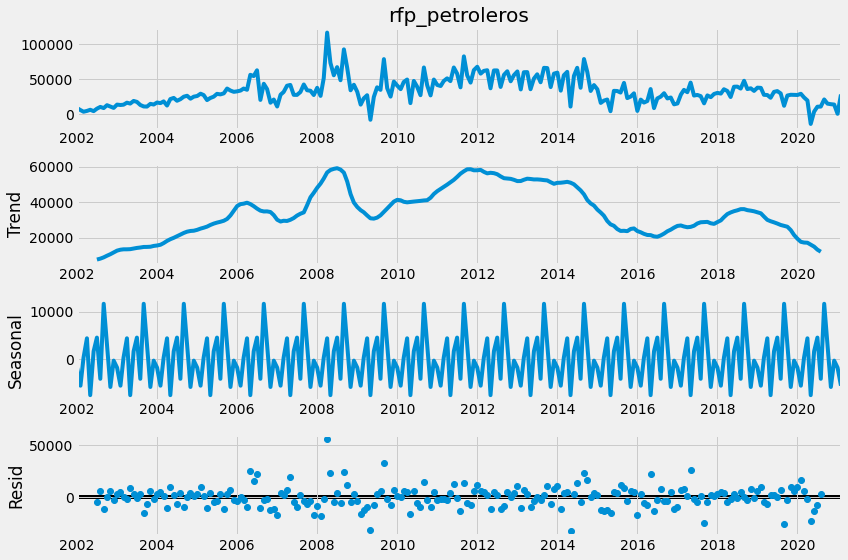

In [110]:
decomposition = seasonal_decompose(fmped, freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show();

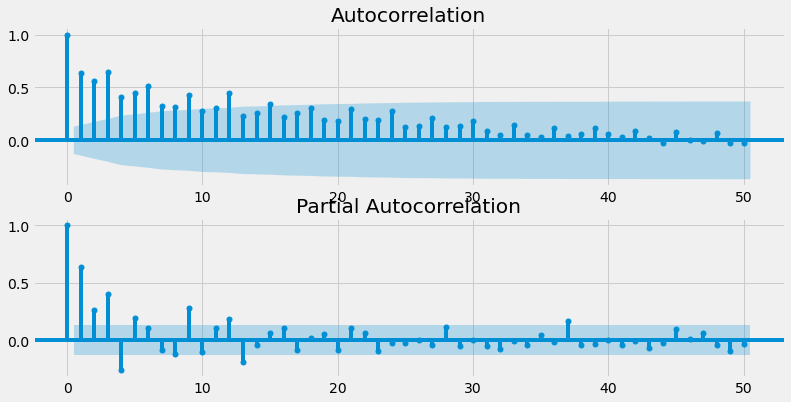

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(fmped, lags=50, ax=ax1)
ax2 = plot_pacf(fmped, lags=50, ax=ax2)
plt.show()

In [112]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(fmped)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.189123
p-value                          0.210217
#Lags Used                      12.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


In [113]:
df_diff = fmped.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2020-10-01   -20806.0
2020-11-01    -1883.5
2020-12-01     -273.1
2021-01-01   -13245.5
2021-02-01    25998.7
Name: rfp_petroleros, dtype: float64

In [114]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.451114e+00
p-value                        1.522675e-08
#Lags Used                     1.500000e+01
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


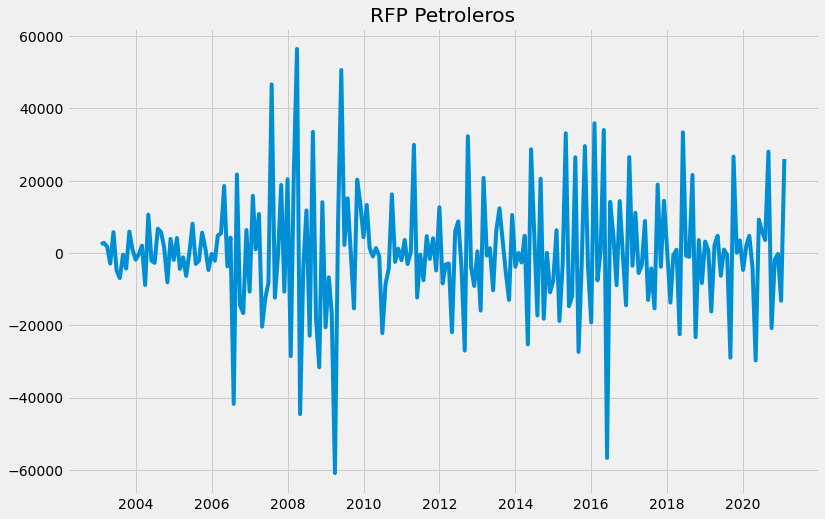

In [117]:
plt.plot(df_diff)
plt.title('RFP Petroleros')
#plt.savefig('diffplot')
plt.show()

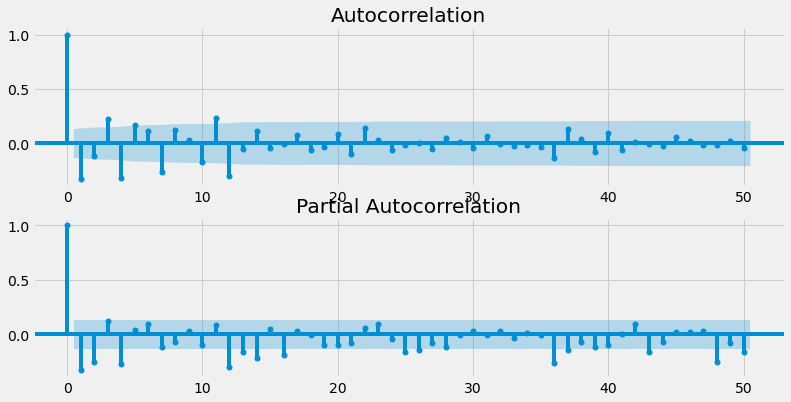

In [118]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [119]:
#import pmdarima as pm
model = pm.auto_arima(fmped, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=4782.870, BIC=4796.390, Fit time=0.422 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4823.699, BIC=4830.459, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4781.772, BIC=4795.292, Fit time=0.169 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4751.454, BIC=4764.973, Fit time=0.268 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4745.727, BIC=4762.626, Fit time=0.782 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4768.575, BIC=4782.095, Fit time=0.184 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4749.597, BIC=4769.877, Fit time=1.123 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4790.656, BIC=4800.796, Fit time=0.072 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4749.742, BIC=4773.401, Fit time=1.859 seconds
Fit ARIMA: order=(1, 1, 1) s

In [120]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  230
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2359.151
Date:                            Thu, 18 Mar 2021   AIC                           4732.303
Time:                                    14:41:37   BIC                           4755.962
Sample:                                         0   HQIC                          4741.860
                                            - 230                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -137.6178    367.084     -0.375      0.708    -857.089     581.853
ar.L1         -0.9589      0.158     -6.071      0.000      -1.268      -0.649
ar.L2         -0.5186      0.082     -6.346      0.000      -0.679      -0.358
ma.L1          0.5714      0.173      3.303      0.001       0.232       0.911
ar.S.L12       0.2607      0.109      2.382      0.017       0.046       0.475
ma.S.L12      -0.8907      0.106     -8.431      0.000      -1.098      -0.684
sigma2      2.171e+08      0.000   1.03e+12      0.000    2.17e+08    2.17e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                95.24
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.27
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.2e+28. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='fecha'>

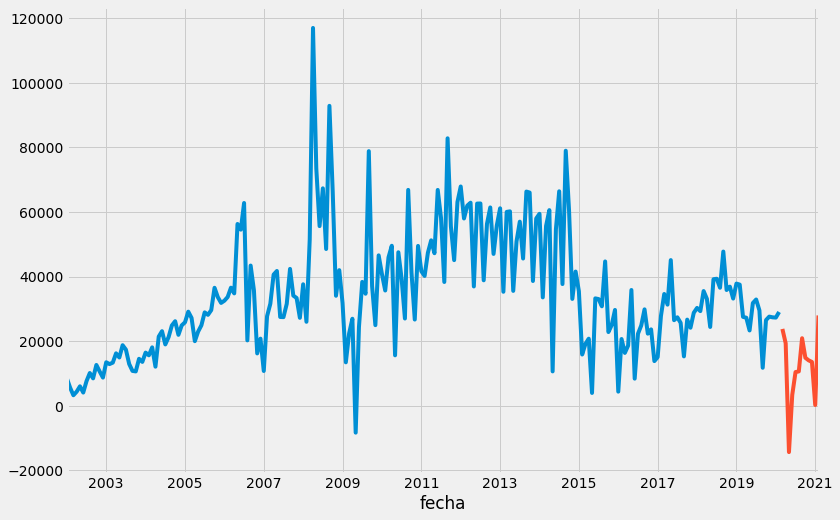

In [121]:
#divide into train and validation set
train = fmped[:int(0.95*(len(fmped)))]
test = fmped[int(0.95*(len(fmped))):]

#plotting the data
train.plot()
test.plot()

In [122]:
model = SARIMAX(train,order=(2,1,1),seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     rfp_petroleros   No. Observations:                  218
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2228.233
Date:                            Thu, 18 Mar 2021   AIC                           4468.465
Time:                                    14:42:13   BIC                           4488.403
Sample:                                01-01-2002   HQIC                          4476.530
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9771      0.153     -6.403      0.000      -1.276      -0.678
ar.L2         -0.5282      0.082     -6.422      0.000      -0.689      -0.367
ma.L1          0.5923      0.167      3.544      0.000       0.265       0.920
ar.S.L12       0.2576      0.107      2.404      0.016       0.048       0.468
ma.S.L12      -0.8983      0.105     -8.550      0.000      -1.104      -0.692
sigma2      2.164e+08   3.99e-10   5.42e+17      0.000    2.16e+08    2.16e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                99.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.32
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+34. Standard errors may be unstable.
"""

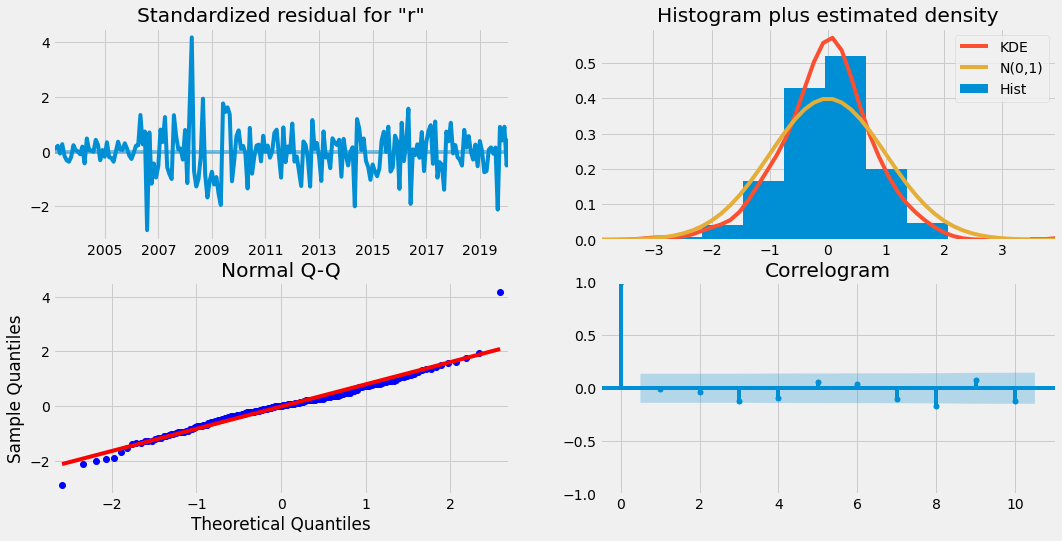

In [124]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

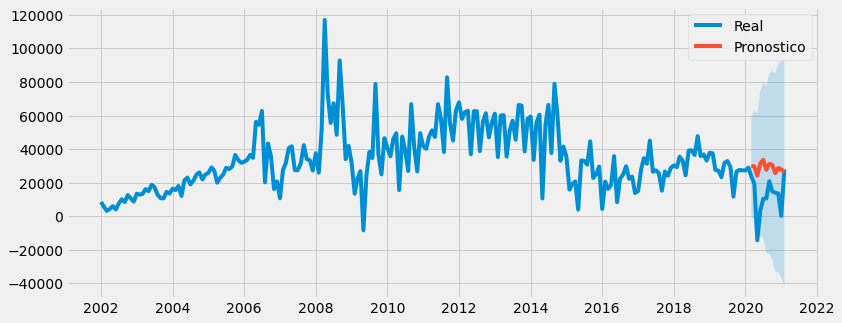

In [125]:
forecast_object = results.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
plt.figure(figsize=(12,5))
# Plot past CO2 levels
plt.plot(fmped.index, fmped, label='Real')
# Plot the prediction means as line
plt.plot(dates, mean, label='Pronostico')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)
# Plot legend and show figure
plt.legend()
#plt.savefig('predtest')
plt.show()

In [126]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX Predictions')

In [127]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=29973.37458, expected=23762.7
predicted=29741.20776, expected=19328.4
predicted=24134.11125, expected=-14365.2
predicted=31474.27289, expected=3335.1
predicted=33632.41381, expected=10415.6
predicted=27661.89738, expected=10608.4
predicted=31182.28851, expected=20884.4
predicted=30648.56162, expected=14831.9
predicted=25762.94442, expected=14038.7
predicted=28778.69129, expected=13542.7
predicted=27956.61469, expected=215.9
predicted=26206.60853, expected=27945.8


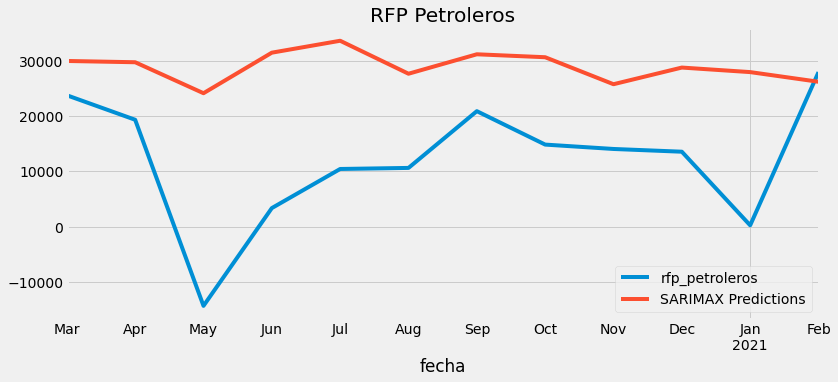

In [128]:
title = 'RFP Petroleros'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [129]:
r2_score(test, predictions)

-2.2678600173368233

In [130]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 
evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0  -2.26786         17173.914139        3.957692e+08   

   mean_absolute_percentage_error  
0                     1231.871774

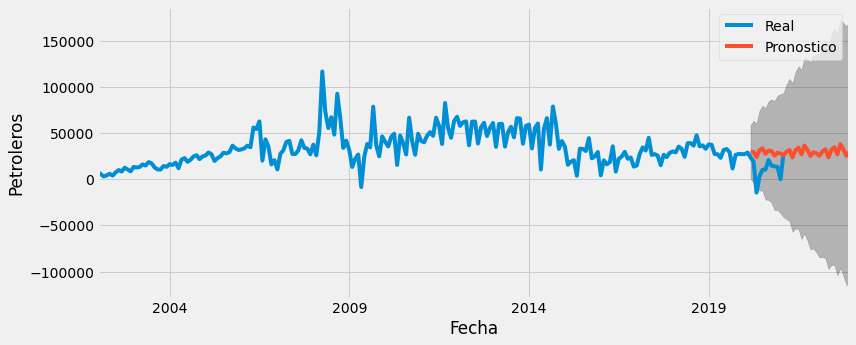

In [132]:
pred_f = results.get_forecast(steps=len(test)+22)
pred_ci = pred_f.conf_int()
ax = fmped.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Petroleros')
plt.legend()
plt.show()

In [133]:
x=pred_f.predicted_mean
x.to_csv('arima_petroleros.csv')

## 4. Análisis de las Series Trimestrales

Como ya señalé en la [parte 1]( ), el Producto Interno Bruto (PIB) resulta ser una variable adecuada para estimar el Impuesto Sobre la Renta (ISR) y el Impuesto al Valor Agregado (IVA), además de otras variables como la reforma al ISR y la tasa misma del IVA, respectivamente. Así que me iré serie por serie, presentando los resultados de manera detallada solo para la primera.

Al igual que antes, solo comentaré la primer serie que es el ISR.

Con esta línea cargo los datos:

In [134]:
df = pd.read_csv('202103trimestrales.csv', sep=',', parse_dates=['fecha'], index_col='fecha', encoding = 'utf-8')
df['fecha']=df.index
df.tail()

ano  mes  dia       fechas     pib_real   pib_reale4         IPI  \
fecha                                                                           
2021-10-01  2021   10    1      2021/04  18126447.11  4531611.778  143.803049   
2022-01-01  2022    1    1  2022/01 /r1  18251292.49  4562823.122  146.988790   
2022-04-01  2022    4    1      2022/02  18354106.33  4588526.582  138.173468   
2022-07-01  2022    7    1      2022/03  18445904.40  4611476.100  150.913887   
2022-10-01  2022   10    1      2022/04  18535866.51  4633966.627  149.246115   

            rfp_neta  isr  iva  rfp_real  isr_real  iva_real  tasa iva  \
fecha                                                                    
2021-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-01-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-04-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-07-01       NaN  NaN  NaN       NaN       NaN       NaN        16   
2022-10-01       NaN  NaN  NaN       NaN       NaN       NaN        16   

            reformaisr  covid      fecha  
fecha                                     
2021-10-01           1      0 2021-10-01  
2022-01-01           1      0 2022-01-01  
2022-04-01           1      0 2022-04-01  
2022-07-01           1      0 2022-07-01  
2022-10-01           1      0 2022-10-01

### 4.1 Impuesto Sobre la Renta, ISR

Una vez que tome en cuenta la serie en términos reales y el desfase de 2 meses que existe en la serie del ISR, la serie mantuvo un crecimiento en términos reales hasta 2017-2018, y a partir de entonces mantiene un compartamiento un poco más vólatil:

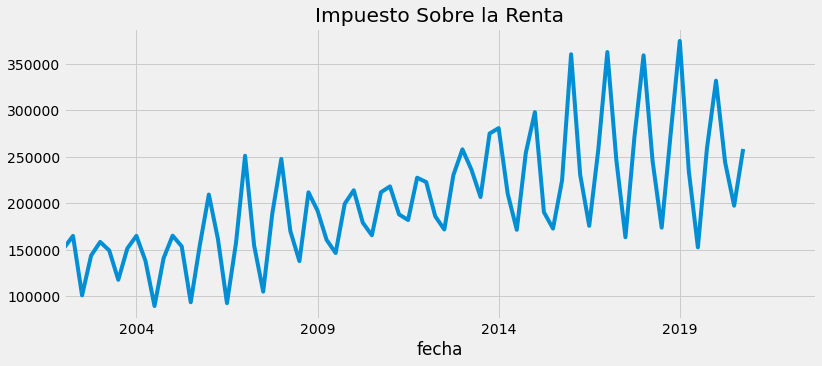

In [135]:
isrp=df['isr_real']
#isr=isrp.dropna()
isrp.plot(figsize=(12,5))
plt.title('Impuesto Sobre la Renta')
plt.show()
#isr.head()

Su histograma y función de densidad se ven como sigue:

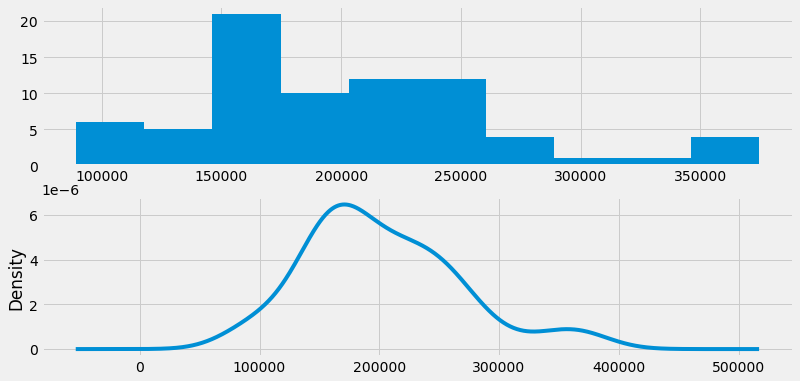

In [136]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))
isrp.hist(ax=ax1)
isrp.plot(kind='kde',ax=ax2)
plt.show()

La descomposición de la serie del ISR se ve como sigue:

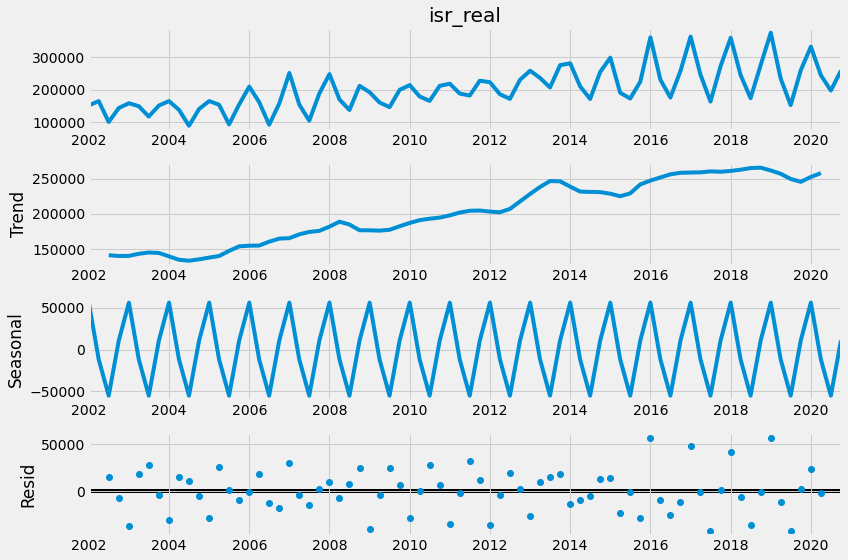

In [140]:
decomposition = seasonal_decompose(isrp.dropna(), freq=4, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

Y debido a que la serie es trimestral, los correlogramas no corren adecuadamente:

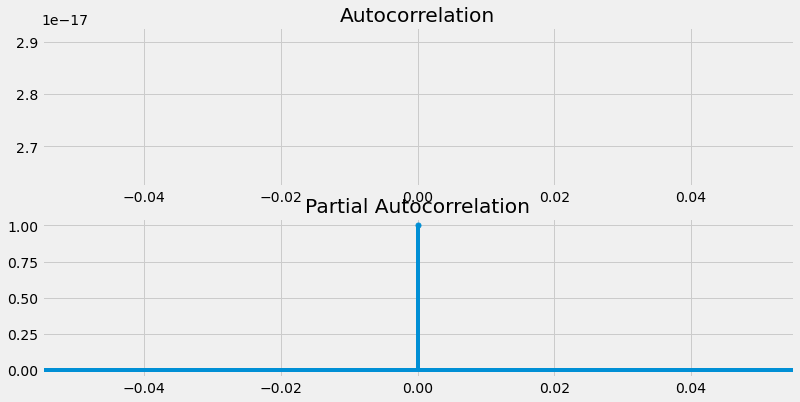

In [141]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(isrp, lags=40, ax=ax1)
ax2 = plot_pacf(isrp, lags=40, ax=ax2)
plt.show()

Aplico la prueba Dickey-Fuller a la serie en niveles y parece indicar que la serie tiene raíz unitaria. Sin embargo, al sacar diferencias, la serie sí parece ser estacionaria:

In [142]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(isrp.dropna())

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.725927
p-value                         0.839919
#Lags Used                      3.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [143]:
df_diff = isrp.diff().diff(4)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2019-10-01     5009.1559
2020-01-01   -26549.3471
2020-04-01    52938.6471
2020-07-01    34666.5004
2020-10-01   -45595.2639
Name: isr_real, dtype: float64

In [144]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -5.253576
p-value                         0.000007
#Lags Used                      7.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


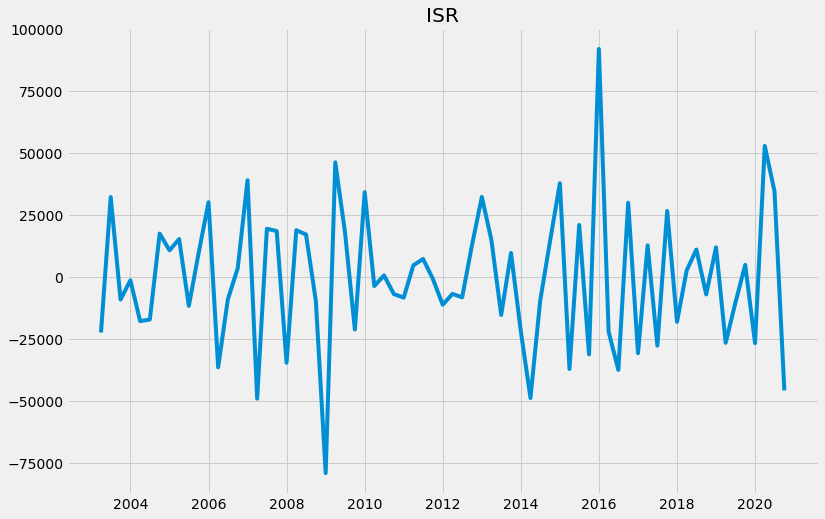

In [145]:
plt.plot(df_diff)
plt.title('ISR')
#plt.savefig('diffplot')
plt.show()

Los correlogramas de la serie en diferencias (aunque generan error)

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 50 must be < 35.

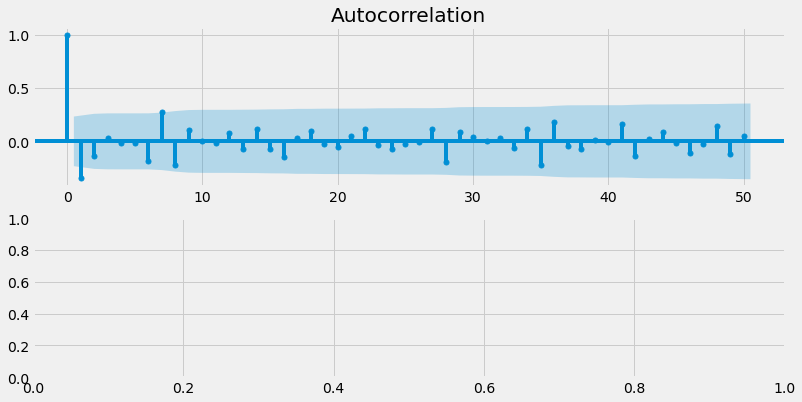

In [146]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

Creo los objetos con las variables explicativas:

In [147]:
pib2x=df[['reformaisr','pib_reale4', 'covid']]
pib2x.drop(pib2x.head(76).index,inplace=True)
pib2x.shape

(8, 3)

In [148]:
pib2=df[['reformaisr','pib_reale4', 'covid']]
pib2.drop(pib2.tail(8).index,inplace=True)
pib2.shape

(76, 3)

Corro la función **auto_arima** inclyendo variables explicativas, y estos son los resultados que me arroja:

In [149]:
model = pm.auto_arima(isrp.dropna(), 
                      exogenous=pib2,
                      d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)                     

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=1530.990, BIC=1545.992, Fit time=0.475 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1530.968, BIC=1541.683, Fit time=0.036 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1529.396, BIC=1544.397, Fit time=0.260 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1510.279, BIC=1525.281, Fit time=0.661 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1509.471, BIC=1526.616, Fit time=0.752 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=1510.446, BIC=1525.447, Fit time=0.327 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1506.453, BIC=1525.741, Fit time=1.631 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1507.913, BIC=1529.345, Fit time=1.468 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=1525.589, BIC=1542.734, Fit time=0.824 seconds
Fit ARIMA: order=(0, 1, 2) s

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 1, 12); AIC=1508.658, BIC=1532.232, Fit time=2.568 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=1501.351, BIC=1518.496, Fit time=0.679 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 0, 12); AIC=1502.435, BIC=1521.723, Fit time=0.778 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1519.591, BIC=1534.592, Fit time=0.401 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=1506.700, BIC=1525.988, Fit time=2.398 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(2, 1, 0, 12); AIC=1507.064, BIC=1528.496, Fit time=3.193 seconds
Total fit time: 29.386 seconds


In [150]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -742.675
Date:                             Thu, 18 Mar 2021   AIC                           1501.351
Time:                                     14:47:54   BIC                           1518.496
Sample:                                          0   HQIC                          1508.094
                                              - 76                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1613.6828   2185.429     -0.738      0.460   -5897.044    2669.679
x1         -4.922e+04   2.04e+04     -2.414      0.016   -8.92e+04   -9255.389
x2             0.0478      0.017      2.748      0.006       0.014       0.082
x3          7.699e+04   3.52e+04      2.187      0.029    7980.998    1.46e+05
ma.L1         -0.6574      0.181     -3.632      0.000      -1.012      -0.303
ar.S.L12      -0.1930      0.160     -1.205      0.228      -0.507       0.121
ar.S.L24      -0.5047      0.140     -3.604      0.000      -0.779      -0.230
sigma2      1.155e+09      0.866   1.33e+09      0.000    1.15e+09    1.15e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.94
Prob(Q):                              0.88   Prob(JB):                         0.23
Heteroskedasticity (H):               0.98   Skew:                             0.52
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+25. Standard errors may be unstable.
"""

Divido la serie en una parte que servirá para entrenamiento y otra para prueba, y procedo a realizar dicho entrenamiento:

<AxesSubplot:xlabel='fecha'>

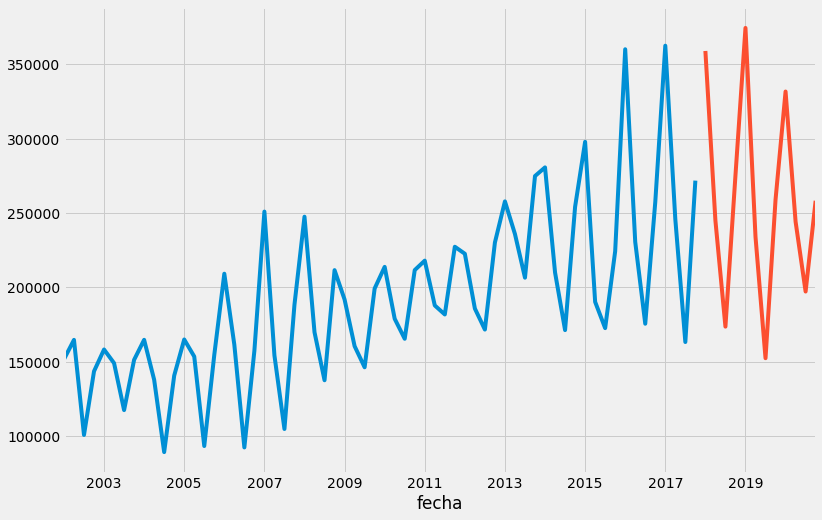

In [151]:
#divide into train and validation set
isr=isrp.dropna()
train = isr[:int(0.85*(len(isr)))]
test = isr[int(0.85*(len(isr))):]
#plotting the data
train.plot()
test.plot()

In [152]:
test.shape

(12,)

In [153]:
isr.shape

(76,)

In [154]:
pib2_train=pib2[:int(0.85*(len(isr)))]
pib2_train=pib2[:int(0.85*(len(isr)))]
pib2_test=pib2[int(0.85*(len(isr))):]
pib2.shape

(76, 3)

In [155]:
model = SARIMAX(train,order=(0,1,1),seasonal_order=(2,1,0,12),exog=pib2_train)
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            isr_real   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -600.725
Date:                             Thu, 18 Mar 2021   AIC                           1215.450
Time:                                     14:49:28   BIC                           1228.973
Sample:                                 01-01-2002   HQIC                          1220.618
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
reformaisr -4.888e+04   3.16e+04     -1.547      0.122   -1.11e+05     1.3e+04
pib_reale4     0.0421      0.020      2.121      0.034       0.003       0.081
covid               0   3.44e+05          0      1.000   -6.73e+05    6.73e+05
ma.L1         -0.7297      0.254     -2.871      0.004      -1.228      -0.231
ar.S.L12      -0.4901      0.349     -1.404      0.160      -1.174       0.194
ar.S.L24      -0.5581      0.204     -2.742      0.006      -0.957      -0.159
sigma2      1.328e+09     51.888   2.56e+07      0.000    1.33e+09    1.33e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.73   Prob(JB):                         0.22
Heteroskedasticity (H):               1.10   Skew:                             0.60
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+24. Standard errors may be unstable.
"""

Los residuales del modelo se comportan adecuadamente:

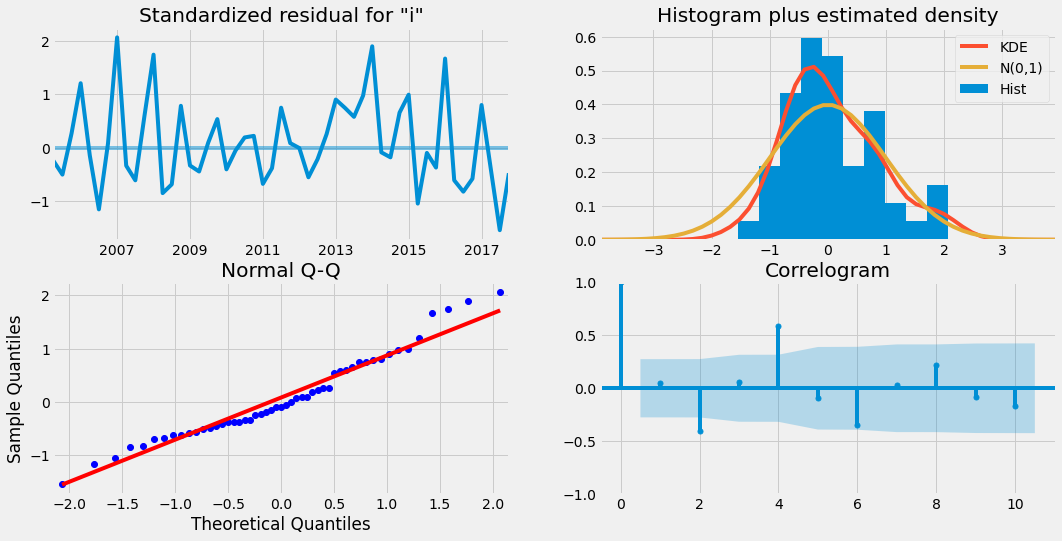

In [156]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

Y el pronóstico en sí, también se ve bastante prometedor.

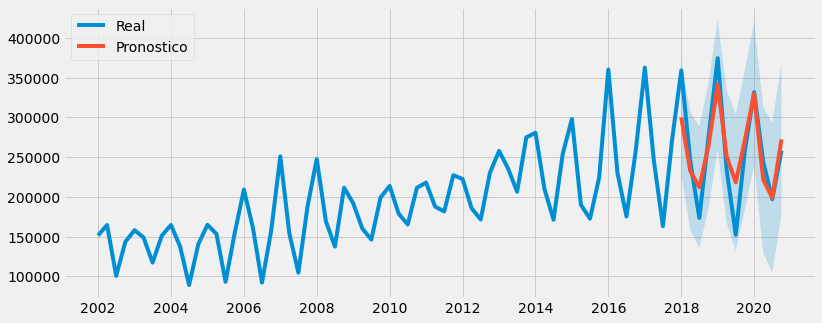

In [157]:
forecast_object = results.get_forecast(steps=len(test), exog=pib2_test)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
plt.figure(figsize=(12,5))
# Plot past CO2 levels
plt.plot(isr.index, isr, label='Real')
# Plot the prediction means as line
plt.plot(dates, mean, label='Pronostico')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
# Plot legend and show figure
plt.legend()
#plt.savefig('predtest')
plt.show()

In [158]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels', exog=pib2_test).rename('SARIMAX')

In [159]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=299958.7662, expected=358984.3242
predicted=232722.5627, expected=244976.5495
predicted=212252.8365, expected=173591.8071
predicted=264196.7539, expected=275218.9115
predicted=341326.6664, expected=374469.276
predicted=250822.7468, expected=234039.3595
predicted=218326.145 , expected=152362.7531
predicted=271828.6774, expected=258999.0134
predicted=329811.07  , expected=331700.0308
predicted=221777.6919, expected=244208.7614
predicted=198902.6774, expected=197198.6554
predicted=272269.3153, expected=258239.6518


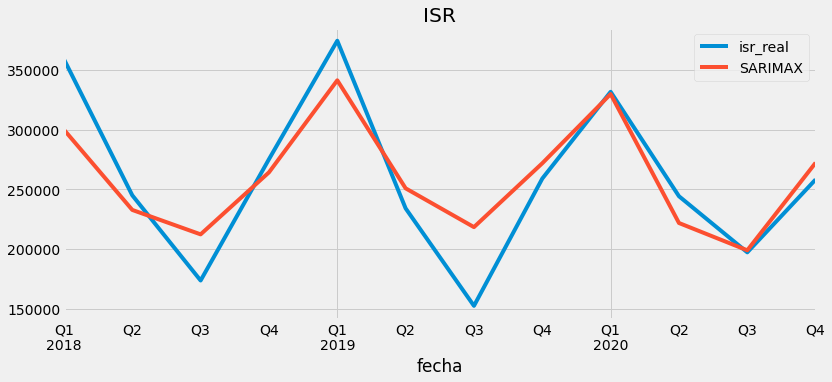

In [160]:
title = 'ISR'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

Calculo los estadísticos del modelo:

In [161]:
r2_score(test, predictions)

0.7738104778457335

In [162]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0   0.77381         24144.625032        9.877233e+08   

   mean_absolute_percentage_error  
0                       10.670094

Creo el vector que tiene las variables explicativas que utilizaré más adelante, y calculo dicho pronóstico:

In [165]:
pib2y=df[['reformaisr','pib_reale4', 'covid']]
#pib2.drop(pib2.tail(7).index,inplace=True)
#reformaisr=df['reformaisr']
#reformaisr.drop(reformaisr.tail(7).index,inplace=True)
pib2y.drop(pib2y.head(64).index,inplace=True)
pib2y.shape

(20, 3)

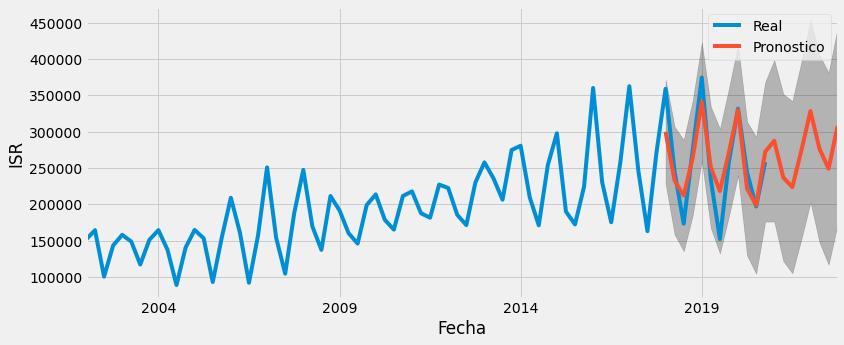

In [166]:
pred_f = results.get_forecast(steps=8+len(test), exog=pib2y)
pred_ci = pred_f.conf_int()
ax = isr.plot(label='Real', figsize=(12, 5))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('ISR')
plt.legend()
plt.show()

In [167]:
x=pred_f.predicted_mean
x.to_csv('arima_isr.csv')

### 4.2 Impuesto al Valor Agregado, IVA

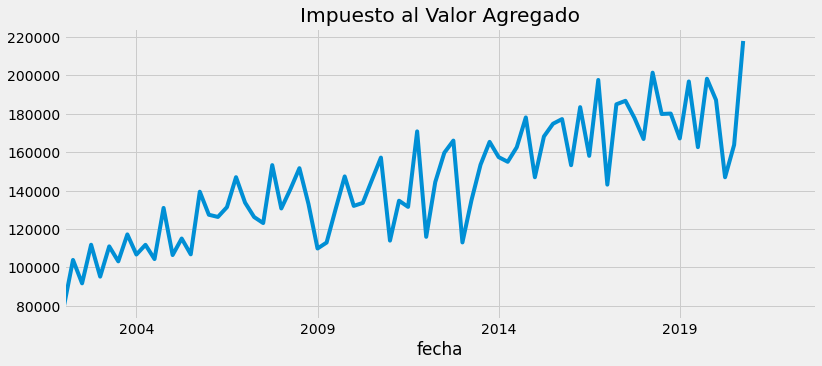

In [168]:
ivap=df['iva_real']
#iva=ivap.dropna()
ivap.plot(figsize=(12,5))
plt.title('Impuesto al Valor Agregado')
plt.show()

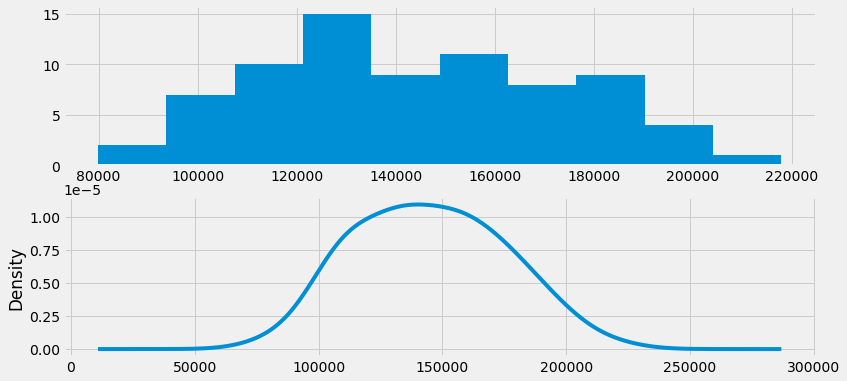

In [169]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))
ivap.hist(ax=ax1)
ivap.plot(kind='kde',ax=ax2)
plt.show()

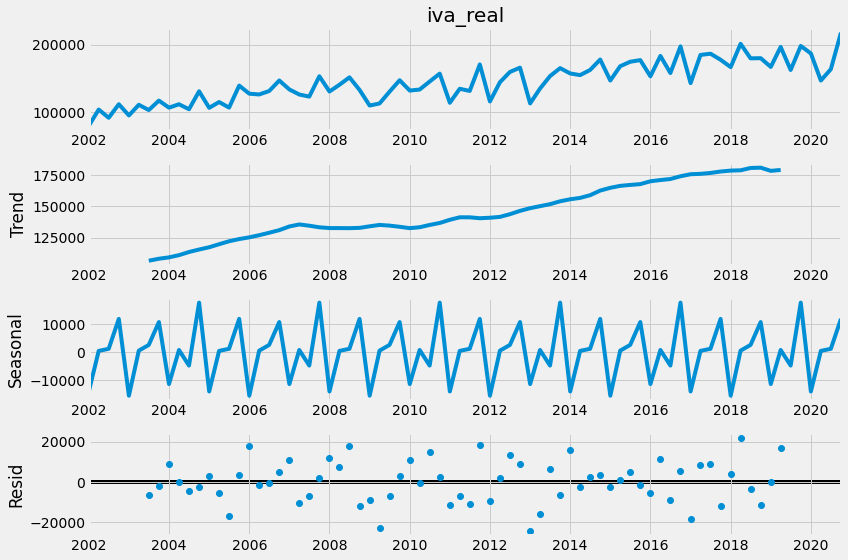

In [170]:
decomposition = seasonal_decompose(ivap.dropna(), freq=12, model='additive')
plt.rcParams['figure.figsize'] = 12, 8
decomposition.plot()
plt.show()

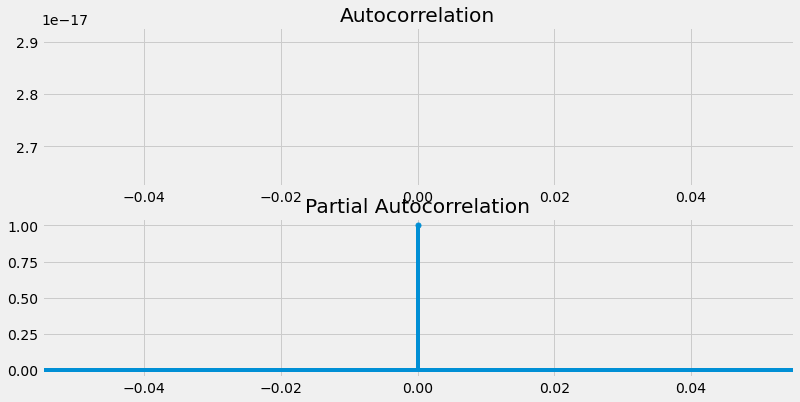

In [172]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(ivap, lags=40, ax=ax1)
ax2 = plot_pacf(ivap, lags=40, ax=ax2)
plt.show()

In [173]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ivap.dropna())

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -1.140196
p-value                         0.698779
#Lags Used                      7.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


In [175]:
df_diff = ivap.diff().diff(4)
df_diff.dropna(inplace=True)
df_diff.tail()

fecha
2019-10-01    35393.0661
2020-01-01     1902.6526
2020-04-01   -69912.0086
2020-07-01    51043.0867
2020-10-01    18496.8900
Name: iva_real, dtype: float64

In [176]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -8.130360e+00
p-value                        1.094447e-12
#Lags Used                     5.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64


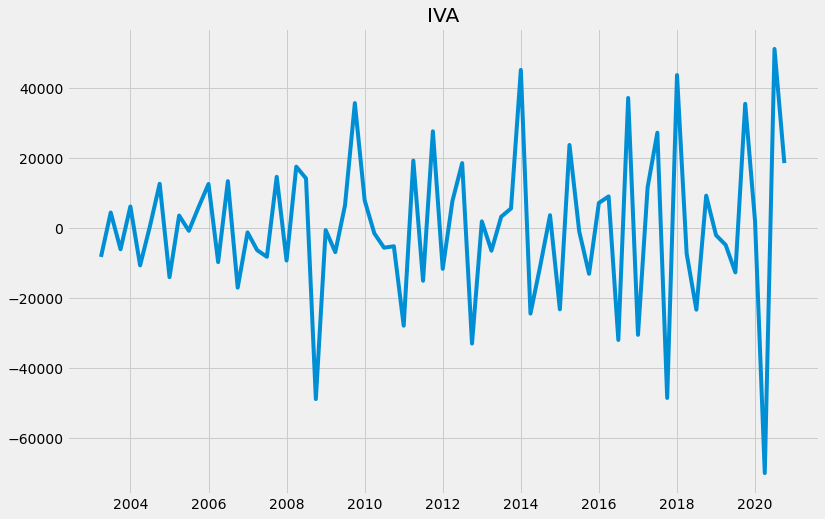

In [177]:
plt.plot(df_diff)
plt.title('IVA')
#plt.savefig('diffplot')
plt.show()

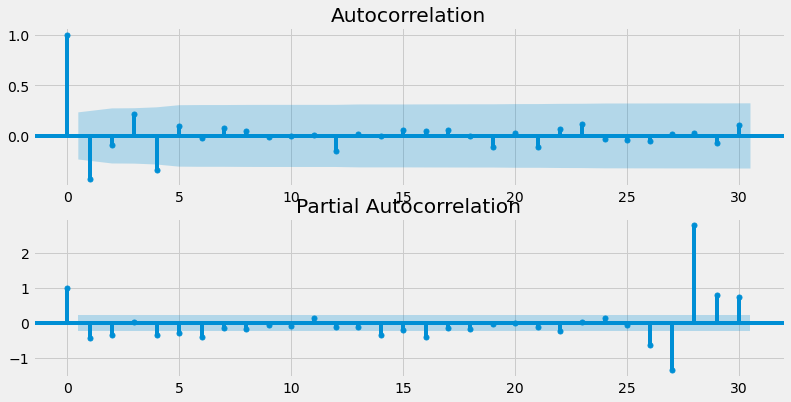

In [178]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=30, ax=ax1)
ax2 = plot_pacf(df_diff, lags=30, ax=ax2)
#plt.savefig('acfpacf2')
plt.show()

In [179]:
pib2x=df[['tasa iva','pib_reale4', 'covid']]
pib2x.drop(pib2x.head(76).index,inplace=True)
pib2x.shape

(8, 3)

In [180]:
pib2=df[['tasa iva','pib_reale4', 'covid']]
pib2.drop(pib2.tail(8).index,inplace=True)
pib2.shape

(76, 3)

In [181]:
model = pm.auto_arima(ivap.dropna(), 
                      exogenous=pib2,
                      d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)                     

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=1439.716, BIC=1454.718, Fit time=0.468 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1449.345, BIC=1460.061, Fit time=0.048 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1440.387, BIC=1455.389, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1431.259, BIC=1446.261, Fit time=0.353 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1432.997, BIC=1450.142, Fit time=0.579 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1443.606, BIC=1456.465, Fit time=0.168 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1432.937, BIC=1450.082, Fit time=0.695 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1427.878, BIC=1447.167, Fit time=1.567 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1429.674, BIC=1451.106, Fit time=1.605 seconds
Fit ARIMA: order=(0, 1, 0) s

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 1, 2, 12); AIC=1432.886, BIC=1456.460, Fit time=2.284 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1429.716, BIC=1451.147, Fit time=1.956 seconds
Total fit time: 12.540 seconds


In [182]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -704.939
Date:                                 Thu, 18 Mar 2021   AIC                           1427.878
Time:                                         14:55:18   BIC                           1447.167
Sample:                                              0   HQIC                          1435.465
                                                  - 76                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2087.3233   2307.489      0.905      0.366   -2435.272    6609.918
x1          1.685e+04   7911.692      2.130      0.033    1341.421    3.24e+04
x2            -0.0003      0.031     -0.009      0.993      -0.061       0.061
x3         -6.107e+04   5.31e+04     -1.149      0.250   -1.65e+05    4.31e+04
ma.L1         -0.2715      0.162     -1.681      0.093      -0.588       0.045
ar.S.L12      -0.7065      0.337     -2.097      0.036      -1.367      -0.046
ma.S.L12       0.3321      0.513      0.648      0.517      -0.672       1.337
ma.S.L24      -0.5412      0.230     -2.350      0.019      -0.993      -0.090
sigma2      3.953e+08      3.387   1.17e+08      0.000    3.95e+08    3.95e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.30   Prob(JB):                         0.90
Heteroskedasticity (H):               1.71   Skew:                            -0.14
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.2e+24. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='fecha'>

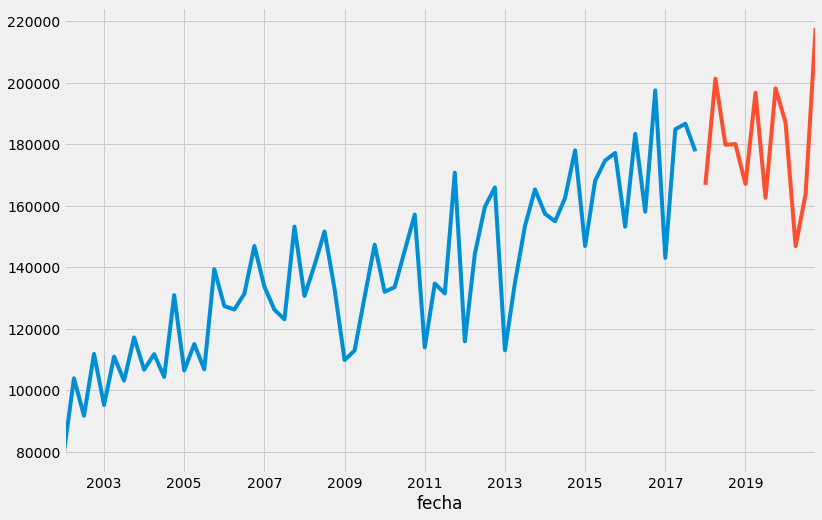

In [183]:
#divide into train and validation set
iva=ivap.dropna()
train = iva[:int(0.85*(len(iva)))]
test = iva[int(0.85*(len(iva))):]
#plotting the data
train.plot()
test.plot()

In [184]:
test.shape

(12,)

In [185]:
iva.shape

(76,)

In [186]:
pib2_train=pib2[:int(0.85*(len(iva)))]
pib2_train=pib2[:int(0.85*(len(iva)))]
pib2_test=pib2[int(0.85*(len(iva))):]
pib2.shape

(76, 3)

In [187]:
model = SARIMAX(train,order=(0,1,1),seasonal_order=(1,1,1,12),exog=pib2_train)
results = model.fit()
results.summary()

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

C:\Users\Homar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           iva_real   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -568.726
Date:                            Thu, 18 Mar 2021   AIC                           1151.453
Time:                                    15:06:54   BIC                           1164.976
Sample:                                01-01-2002   HQIC                          1156.620
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa iva    1.724e+04   5982.499      2.881      0.004    5510.417     2.9e+04
pib_reale4    -0.0426      0.023     -1.828      0.068      -0.088       0.003
covid               0     10.998          0      1.000     -21.556      21.556
ma.L1         -0.5928      0.169     -3.502      0.000      -0.925      -0.261
ar.S.L12      -0.1890      0.360     -0.524      0.600      -0.895       0.517
ma.S.L12      -0.5098      0.446     -1.144      0.253      -1.384       0.364
sigma2      3.382e+08      0.188    1.8e+09      0.000    3.38e+08    3.38e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.20
Prob(Q):                              0.97   Prob(JB):                         0.12
Heteroskedasticity (H):               0.64   Skew:                            -0.70
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.79e+24. Standard errors may be unstable.
"""

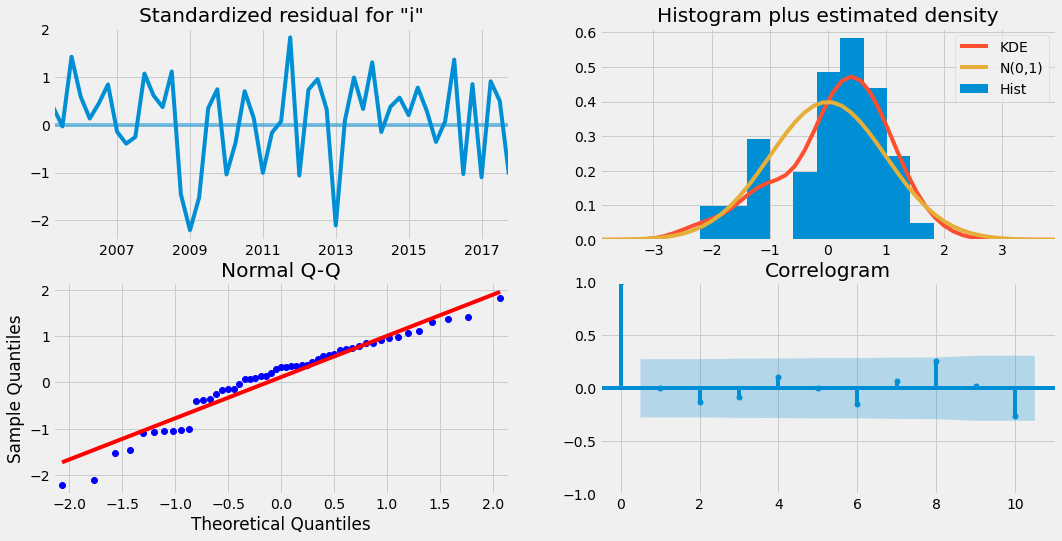

In [188]:
results.plot_diagnostics(figsize=(16, 8))
#plt.savefig('modeldiagnostics2')
plt.show()

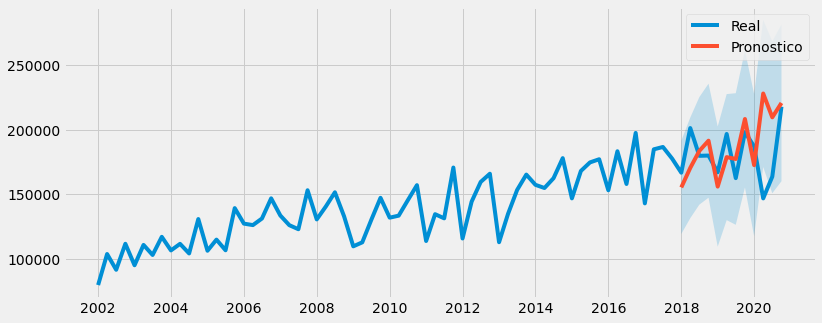

In [189]:
forecast_object = results.get_forecast(steps=len(test), exog=pib2_test)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
plt.figure(figsize=(12,5))
# Plot past CO2 levels
plt.plot(iva.index, iva, label='Real')
# Plot the prediction means as line
plt.plot(dates, mean, label='Pronostico')
# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],alpha=0.2)
# Plot legend and show figure
plt.legend()
#plt.savefig('predtest')
plt.show()

In [190]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels', exog=pib2_test).rename('SARIMAX')

In [191]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=155422.5867, expected=166842.1871
predicted=170520.8617, expected=201371.0823
predicted=183685.7048, expected=179866.4655
predicted=191580.3581, expected=180091.282
predicted=156062.4635, expected=167120.6811
predicted=178878.5628, expected=196796.7433
predicted=177410.9642, expected=162605.6068
predicted=208386.8391, expected=198223.4894
predicted=172695.0973, expected=187155.5411
predicted=228101.4451, expected=146919.5947
predicted=209666.6979, expected=163771.5449
predicted=220771.0206, expected=217886.3175


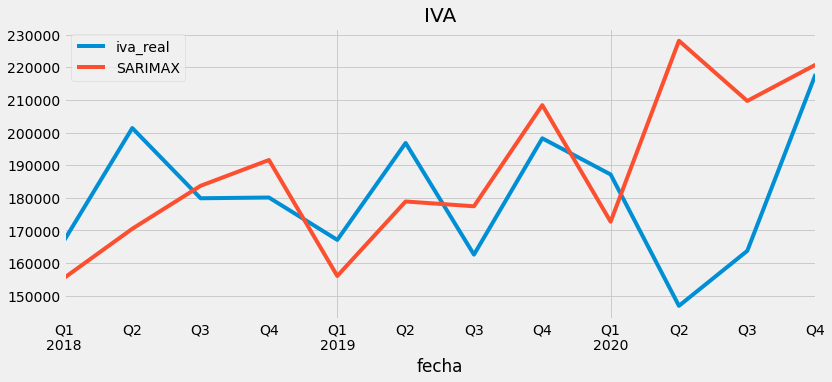

In [192]:
title = 'IVA'
ax = test.plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [193]:
r2_score(test, predictions)

-1.397254429159493

In [194]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test, predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test, predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test)/np.abs(test))*100 

evaluation_results

r2_score  mean_absolute_error  mean_squared_error  \
0 -1.397254          21328.78265        9.090709e+08   

   mean_absolute_percentage_error  
0                       12.745996

In [195]:
pib2y=df[['tasa iva','pib_reale4', 'covid']]
#pib2.drop(pib2.tail(7).index,inplace=True)
#reformaisr=df['reformaisr']
#reformaisr.drop(reformaisr.tail(7).index,inplace=True)
pib2y.drop(pib2y.head(64).index,inplace=True)
pib2y.shape

(20, 3)

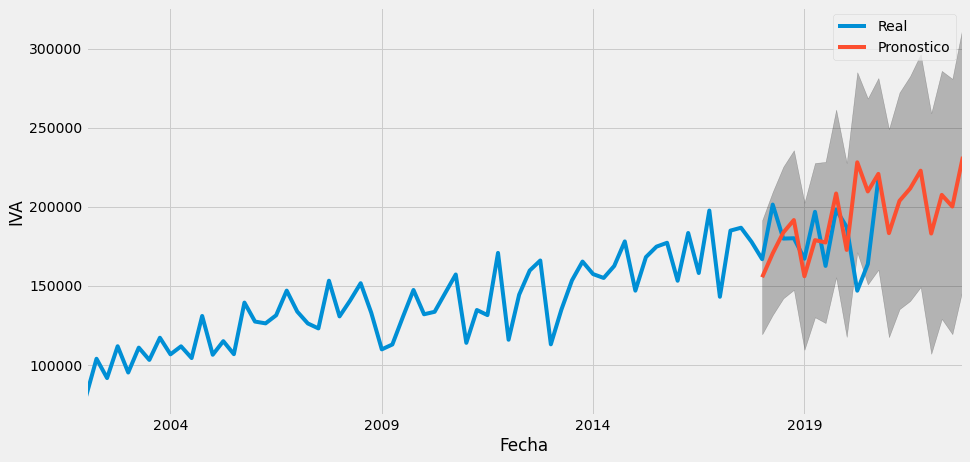

In [196]:
pred_f = results.get_forecast(steps=8+len(test), exog=pib2y)
pred_ci = pred_f.conf_int()
ax = iva.plot(label='Real', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('IVA')
plt.legend()
plt.show()

In [197]:
x=pred_f.predicted_mean
x.to_csv('arima_iva.csv')

Cierro esta *notebook* sin conclusiones. Pueden consultarlas en la respectiva publicación [aquí](https://gonzalezhomar.netlify.app/post/pronostico_2_autoarima/).